# TERCER NOTEBOOK - TOPIC MODELING LDA (LEMMATIZATION) - OBSERVACIONES

**Contenido**

1. Diseño del algoritmo
2. Evaluación modelos LDA ( Mallet | Gensim | Sklearn )
3. Resultados del mejor modelo LDA  
4. Extracción de información  

El objetivo de este tercer notebook es el diseño e implementación de un algoritmo basado en las probabilidades de ocurrencia de palabras (LDA) en las columnas que contienen texto no estructurado, con el fin de agrupar (clustering) palabras de similar contenido, logrando identificar patrones de falla e información importante para la toma de decisiones.

Paralelamente se busca identificar el mejor modelo LDA entre tres opciones, por medio de la evaluación de los coeficientes de coherencia y el contenido semántico. 

## I. DISEÑO DEL ALGORITMO

#### Importar paquetes

In [1]:
import re, pickle, spacy, numpy as np, pandas as pd
from pprint import pprint
from wordcloud import WordCloud
import matplotlib.colors as mcolors
from collections import Counter

# Gensim
import gensim, gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis, pyLDAvis.sklearn, pyLDAvis.gensim  
import matplotlib.pyplot as plt

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter('ignore')
pd.options.mode.chained_assignment = None  # default='warn' ---> Not showing warnings about iloc

# Stop Words
with open('../spanish4.0.txt','r') as f:
    stop_words = f.read().splitlines()
    
# NLP from Spacy
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

#### Estructura del algoritmo

In [3]:
# MODELOS LDA

def texts_id2word_corpus(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN']):  
    # Tokenization
    texts = [gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in texts]
    # Remove stopwords
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # lemmatization
    texts_out = []
    for sent in texts:
        doc = nlp(u" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out] 
    # Create Dictionary
    id2word = corpora.Dictionary(texts_out)
    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts_out]
    return texts_out,id2word,corpus

def coherence_values_mallet(dictionary, corpus, texts, start=2, limit=31, step=2):
    coherence_values = []
    model_list = []
    mallet_path = 'C:/Users/alexa/mallet-2.0.8/bin/mallet.bat' 
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                 corpus=corpus, 
                                                 num_topics=num_topics, 
                                                 id2word=dictionary, 
                                                 random_seed = 1996)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def coherence_values_gensim(dictionary, corpus, texts, start=2, limit=31, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary, 
                                                num_topics=num_topics, 
                                                random_state=1996, 
                                                update_every=1, 
                                                chunksize=100, 
                                                passes=10, 
                                                alpha='auto', 
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def coherence_values_sklearn(data_lemmatized, start=2, limit=31, step=2):
    data_lemmatized2 = [' '.join(sent) for sent in data_lemmatized]
    cv = CountVectorizer(stop_words = stop_words,max_df=0.95, min_df=2)
    data_cv = cv.fit_transform(data_lemmatized2) # document term-matrix (dtm)
    coherence_values = []
    model_list = [] 
    for num_topics in range(start, limit, step):
        model = LatentDirichletAllocation(n_components=num_topics,          
                                          max_iter=10,               
                                          learning_method='online',   
                                          random_state=1996,           
                                          batch_size=128,            
                                          n_jobs = -1)
        model.fit(data_cv)
        model_list.append(model)
        coherencemodel = metric_coherence_gensim(measure='c_v', 
                                                 top_n=20, 
                                                 topic_word_distrib=model.components_, 
                                                 dtm=data_cv, 
                                                 vocab= np.array([x for x in cv.vocabulary_.keys()]),
                                                 texts = data_lemmatized)
        coherencemodel = np.array(coherencemodel)
        coherence_values.append(np.mean(coherencemodel))
    return model_list, coherence_values , cv

def plot_coherence(cv1,cv2,cv3, start=2,limit=31,step=2, save=False, figsize = (10,5)):
    x = range(start, limit, step) 
    plt.rcParams.update({'figure.figsize':figsize})
    plt.plot(x, cv1 , label = 'LDA Mallet')
    plt.plot(x, cv2 , label = 'LDA Gensim')
    plt.plot(x, cv3 , label = 'LDA Sklearn')
    plt.title('LDA Coherence')
    plt.xlabel("Topics")
    plt.ylabel("Coherence score")
    plt.legend()
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha = 0.1)
    if save:
        plt.savefig('plot coherence.jpg', dpi= 200, quality=95)
    plt.show()

def coherence_summary(cv_mallet, cv_gensim, cv_sklearn, start=2,limit=31,step=2):
    num_topics = list(range(start,limit,step))
    d = {'Nro Tópicos': num_topics , 'LDA Mallet': cv_mallet, 'LDA Gensim': cv_gensim, 'LDA Sklearn': cv_sklearn}
    return pd.DataFrame(d)
    
def top15words_sklearn(lda_model, cv):
    for index,topic in enumerate(lda_model.components_):
        print(f'TOPIC {index}')
        words = [cv.get_feature_names()[i] for i in topic.argsort()[-15:]]
        print(words[::-1])
        print('\n')

##### Visualización 

In [4]:
# VISUALIZACIÓN
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

def plot_freqdist(doc_lens, bins = None, xtick=300, width_text = 0.8, height_text = 0.65, save = False, figsize = (10,7)):
    import seaborn as sns
    mean = round(np.mean(doc_lens))
    median = round(np.median(doc_lens))
    stdev = round(np.std(doc_lens))
    oneperc = round(np.quantile(doc_lens, q=0.01))
    nnineperc = round(np.quantile(doc_lens, q=0.99))
    
    plt.figure(figsize=figsize)
    plt.hist(doc_lens, bins = bins, color='royalblue')
    plt.text(width_text, height_text, f'Mean: {mean} \n\nMedian: {median} \n\nStdev: {stdev} \n\n1%ile: {oneperc} \n\n99%ile: {nnineperc}', transform=plt.gca().transAxes)
    plt.gca().set(ylabel='Número de documentos', xlabel='Cantidad de palabras')
    plt.title('Distribución de la cantidad de palabras por documento')
    sns.kdeplot(doc_lens, color="gray", shade=False, ax=plt.gca().twinx())
    #plt.tick_params(size=16)
    plt.xticks(np.linspace(0,xtick,11))
    plt.xlim(0,xtick)
    if save:
        plt.savefig('freq dist total.jpg', dpi= 200, quality=95)
    plt.show()
    
def plot_freqdist_topic(doc_lens, bins = None,rows = 8, cols = 2, width_text = 0.76, height_text = 0.68, figsize= (15,40), save = False):
    import seaborn as sns
    fig, axes = plt.subplots(rows,cols,figsize=figsize, sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):    
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        
        mean = round(np.mean(doc_lens))
        median = round(np.median(doc_lens))
        stdev = round(np.std(doc_lens))
        
        ax.hist(doc_lens, bins= bins, color=colors[i])
        ax.tick_params(axis='y', labelcolor=colors[i], color=colors[i])
        sns.kdeplot(doc_lens, color='gray', shade=False, ax=ax.twinx())
        ax.set(xlim=(0, 200), xlabel='Cantidad de palabras')
        ax.set_ylabel('Número de documentos', color=colors[i])
        ax.set_title('Tópico '+str(i), fontdict=dict(color=colors[i]))
        ax.set_xticks(np.linspace(0,200,11))
        plt.text(width_text, height_text, f'Mean: {mean} \n\nMedian: {median} \n\nStdev: {stdev}', transform=plt.gca().transAxes)
    fig.tight_layout(pad= 1.2)
    fig.subplots_adjust(top=0.90)
    #plt.xticks(np.linspace(0,200,11))
    if save:
        plt.savefig('freq dist total per topic.jpg', dpi= 200, quality=95)
    plt.show()
    
def word_cloud(lda_model,rows=4, cols=4, figsize = (14,16), save = False):
    # figsize = (width,height)
    cloud = WordCloud(stopwords=stop_words,background_color='white',width=2500,height=1800,max_words=15,colormap='tab10',color_func=lambda *args, **kwargs: colors[i],prefer_horizontal=1.0)
    topics = lda_model.show_topics(formatted=False,num_topics=100,num_words=15)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)

        
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Tópico ' + str(i), fontdict=dict(size=12), fontweight='bold')
        plt.gca().axis('off')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout(pad=2)
    if save:
        plt.savefig('word cloud.jpg', dpi= 200, quality=95)
    plt.show()

colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#ffe119', '#800000', '#3cb44b', '#808000', '#f58231', '#000075', '#a9a9a9', '#000000','#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#ffe119', '#800000', '#3cb44b', '#808000', '#f58231', '#000075', '#a9a9a9', '#000000']    

In [5]:
# EVOLUCIÓN DEL TÓPICO EN EL TIEMPO
def topic_timeline(name, namecol,topic_nro, df_topic, figsize = (12,6), save = False):
    
    if name!=None and namecol!=None:
        df_topic = df_topic[df_topic[namecol] == name]
    df = df_topic[df_topic['Topico Dominante'] == topic_nro]
    c = colors[topic_nro]
    
    plt.figure(1)
    
    if name!=None and namecol!=None:
        plt.suptitle(f"Timeline - Tópico {topic_nro} en {namecol} {name}",  fontweight="bold", fontdict={'fontsize':10})
    else:
        plt.suptitle(f"Timeline - Tópico {topic_nro}",  fontweight="bold", fontdict={'fontsize':10})
        
    plt.rcParams.update({'figure.figsize':figsize})
    #print((f"\033[1mCantidad de meses: {len(sorted(df['Mes'].unique()))}\033[0m")) # Nro de meses
    meses = Counter(df["Mes"]) # Cantidad de mantenciones por mes
    #print(meses)
    plt.subplot(321)
    mi = ['JUL 18','AGO 18','SEP 18','OCT 18','NOV 18','DIC 18','ENE 19','FEB 19','MAR 19','ABR 19','MAY 19','JUN 19','JUL 19', 'AGO 19']
    mv = [meses[i] for i in mi]
    plt.plot(mi, mv, color = c, marker = 'o')
    plt.title(f"Cantidad de OT por mes en tópico {topic_nro}", fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xticks(rotation=30)
    #plt.ylim(1200,2000)
    #plt.savefig('7.1) Mes.jpg', dpi= 200, quality=95)
    #plt.show()

    # -----------------------------------------------------------
    plt.subplot(322)
    #print((f"\033[1mCantidad de días: {len(sorted(df['Dia'].unique()))}\033[0m")) # Nro de dias
    n_dias = Counter(df['Nro Dia']) # Cantidad de mantenciones por número de dias
    #print(n_dias)
    d4 = n_dias.most_common(31)
    ni = [i for i,v in d4][::-1]
    nv = [v for i,v in d4][::-1]
    #plt.rcParams['figure.figsize'] = figsize
    plt.bar(ni, nv, align='center', color = c)
    plt.title(f"Cantidad de OT por día en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xlabel('Dias')
    plt.xticks(range(1,32))
    #plt.savefig('7.2) Dia_nro.jpg', dpi= 200, quality=95)
    #plt.show()

    # -----------------------------------------------------------
    plt.subplot(323)
    dias = Counter(df["Dia"]) # Cantidad de mantenciones por dia
    #print(dias)
    di = ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo']
    dv = [dias[i] for i in di]
    #plt.rcParams['figure.figsize'] = figsize
    plt.plot(di, dv, color = c, marker = 'o')
    plt.title(f"Cantidad de OT por día semanal en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xticks(rotation=0)
    #plt.savefig('7.3) Dia_semana.jpg', dpi= 200, quality=95)
    #plt.show()

    # -----------------------------------------------------------
    plt.subplot(324)
    #print((f"\033[1mCantidad de horas en Recepción OT: {len(sorted(df['Hora'].unique()))}\033[0m")) # Nro de horas
    horas = Counter(df["Hora"]) # Cantidad de mantenciones por rango de hora
    #print(horas)
    d3 = horas.most_common(30)
    hi = [i for i,v in d3][::-1]
    hv = [v for i,v in d3][::-1]
    #plt.rcParams['figure.figsize'] = figsize
    plt.bar(hi, hv, align='center', color = c)
    plt.title(f"Cantidad de OT por hora en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.xlabel('Horas')
    plt.ylabel('Número de OT')
    plt.xticks(range(0,24))
    #plt.savefig('7.4) Hora.jpg', dpi= 200, quality=95)
    #plt.show()

    # -----------------------------------------------------------
    plt.subplot(325)
    #print((f"\033[1mDiferencia de tiempo entre la Recepción OT y el Arribo de Técnico: {len(sorted(df['Rango Recep/Arribo'].unique()))}\033[0m")) # Rango recep/arribo
    recep_arribo = Counter(df['Rango Recep/Arribo'])
    #print(recep_arribo)

    rango_di = ['0 a 24 horas', '1 a 2 días', '2 a 3 días','3 a 4 días','4 a 5 días','5 a 6 días','6 a 7 días', '1 a 2 semanas',
               '2 a 3 semanas','3 a 4 semanas','Más de 1 mes','Error en fechas']
    rango_dv = [recep_arribo[i] for i in rango_di]

    #plt.rcParams['figure.figsize'] = figsize
    plt.plot(rango_di, rango_dv, color = c, marker = 'o')
    plt.title(f"Tiempo entre recepción OT y arribo de técnico en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xticks(rotation=50)
    #plt.savefig('7.5) Recepción OT y arribo de técnico asignado.jpg', dpi= 200, quality=95)
    #plt.show()
    
    # -----------------------------------------------------------
    plt.subplot(326)
    #print((f"\033[1mDiferencia de tiempo entre el Arribo y Cierre de trabajo: {len(sorted(df['Rango Arribo/Cierre'].unique()))}\033[0m")) # Rango arribo/cierre
    arribo_cierre = Counter(df['Rango Arribo/Cierre'])
    #print(arribo_cierre)

    rango_hi = ['Menos de 1h', '1 a 2 horas','2 a 3 horas','3 a 4 horas','4 a 5 horas','5 a 6 horas','6 a 7 horas',
              '7 a 8 horas','8 a 24 horas','1 a 3 días','3 a 7 días','1 a 4 semanas','Más de 1 mes','Error en horas']
    rango_hv = [arribo_cierre[i] for i in rango_hi]

    #plt.rcParams['figure.figsize'] = figsize
    plt.bar(rango_hi, rango_hv, color = c, align='center', width = 0.6)
    plt.title(f"Tiempo entre arribo y cierre de trabajo en tópico {topic_nro}",fontweight= 'bold', fontsize = 10)
    plt.ylabel('Número de OT')
    plt.xticks(rotation=50)
    #plt.savefig('7.6) Tiempo entre arribo  y cierre de trabajo.jpg', dpi= 200, quality=95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    
    if name!=None and namecol!=None:
        if save: 
            plt.savefig(f'Timeline - Topic {topic_nro} en {namecol} {name}.jpg', dpi= 200, quality=95)
    else: 
        if save: 
            plt.savefig(f'Timeline - Topic {topic_nro}.jpg', dpi= 200, quality=95)
    plt.show()
    
# DISTRIBUCIÓN 6 PRINCIPALES TÓPICOS DE UNA COLUMNA EN TOP 9 (PIE)
def topics_top9(namecol, df, figsize = (18,14), save = False, angle = 100):
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice
    
    estacion_total= Counter(df[namecol])
    d = estacion_total.most_common(9)
    keys_est_total = [i for i,v in d][::-1]
    values_est_total = [v for i,v in d][::-1]
    
    for index, est in enumerate(keys_est_total[::-1]):
        df_est = df[df[namecol] == est]
        tfalla_total = Counter(df_est["Topico Dominante"])
        dic_tfallatotal = tfalla_total.most_common(6)

        keys = [f'Tópico {i}' for i,v in dic_tfallatotal][::-1]
        values = [v for i,v in dic_tfallatotal][::-1]
        plt.subplot(3,3,index+1)
        plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
        plt.axis('equal')
        plt.title((f'{index+1}) {est}'), fontweight="bold", fontdict={'fontsize':10})
    if save:
        plt.savefig(f'{namecol} top 9.jpg', dpi= 200, quality=95)
    plt.show()
    
# DISTRIBUCIÓN 6 PRINCIPALES TÓPICOS EN UNA COLUMNA DE UNA ENTIDAD CUALQUIERA (PIE)
def topics_top1(name, namecol, df, angle=100,figsize = (18,14), save = False):
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice

    df_est = df[df[namecol] == name]
    tfalla_total = Counter(df_est["Topico Dominante"])
    dic_tfallatotal = tfalla_total.most_common(6)

    keys = [f'Tópico {i}' for i,v in dic_tfallatotal][::-1]
    values = [v for i,v in dic_tfallatotal][::-1]
    plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
    plt.axis('equal')
    plt.title((f'{name}'), fontweight="bold", fontdict={'fontsize':12})
    if save:
        plt.savefig(f'{name} - {namecol}.jpg', dpi= 200, quality=95)
    plt.show()
    
# DISTRIBUCION DE TOPICOS TOTAL (BAR)
def topic_distribution(name, namecol, df_topic,s=111, vplus = 12, fontsize= 10, figsize= (12,10), save = False):
    if name!=None and namecol!=None:
        df_topic = df_topic[df_topic[namecol] == name]
    topicos = Counter(df_topic['Topico Dominante']) 
    ti = list(f'Tópico {i}'for i in range(0,len(topicos)))
    tv = [topicos[i] for i in range(0,len(topicos))]

    ax = plt.subplot(s)
    plt.rcParams.update({'figure.figsize':figsize})
    barlist = ax.barh(ti, tv, align='center', height = 0.5)

    for i, v in enumerate(tv):
        ax.text(v+vplus , i , str(v), color='black', va='center')
    for i in range(0,len(topicos)):
        barlist[i].set_color(colors[i])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    if name!=None and namecol!=None:
        plt.title(f"Distribución de OT por tópico en {namecol} {name}",  fontweight="bold", fontdict={'fontsize':fontsize})
        if save: 
            plt.savefig(f'Topic distribution barplot {name} - {namecol}.jpg', dpi= 200, quality=95)
    else: 
        plt.title("Distribución de OT por tópico",  fontweight="bold", fontdict={'fontsize':fontsize})
        if save: 
            plt.savefig('Topic distribution - barplot.jpg', dpi= 200, quality=95)
    plt.show()

# DISTRIBUCIÓN DE 2 ATRIBUTOS AL INTERIOR DE CUALQUIER TÓPICO (POR DEFECTO ESTACION Y TECNICO ASIGNADO)    
def topic_col1_col2 (topic_nro, namecol1, namecol2, df, angle=100,figsize = (12,7), save = False):
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice 
    df_est = df[df['Topico Dominante'] == topic_nro]
    
    plt.figure(1)
    plt.suptitle(f"Tópico {topic_nro}",  fontweight="bold", fontdict={'fontsize':14})
    
    plt.subplot(121)
    tfalla_total = Counter(df_est[namecol1])
    dic_tfallatotal = tfalla_total.most_common(6)
    keys = [i for i,v in dic_tfallatotal][::-1]
    values = [v for i,v in dic_tfallatotal][::-1]
    plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
    plt.axis('equal')
    plt.title((f'Top 6 {namecol1}'), fontweight="bold", fontdict={'fontsize':11})

    plt.subplot(122)
    tfalla_total2 = Counter(df_est[namecol2])
    dic_tfallatotal2 = tfalla_total2.most_common(6)
    keys2 = [i for i,v in dic_tfallatotal2][::-1]
    values2 = [v for i,v in dic_tfallatotal2][::-1]
    plt.pie(values2,explode = explode, labels = keys2, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
    plt.axis('equal')
    plt.title((f'Top 6 {namecol2}'), fontweight="bold", fontdict={'fontsize':11})
    
    if save:
        plt.savefig(f'Top {namecol1} y {namecol2}-Tópico {topic_nro}.jpg', dpi= 200, quality=95)
    plt.show()

# DISTRIBUCIÓN DE 1 ATRIBUTO AL INTERIOR DE CUALQUIER TÓPICO 
def topic_namecol1(topic_nro, namecol, df, angle=100,figsize = (12,7), save = False, fontsize=12):
    plt.rcParams.update({'figure.figsize':figsize})
    colors2 = ['gold', 'yellowgreen', 'lightskyblue','royalblue','coral','turquoise']
    explode = (0, 0, 0, 0, 0, 0.1)  # explode 1st slice
    df_est = df[df['Topico Dominante'] == topic_nro]
    tfalla_total = Counter(df_est[namecol])
    dic_tfallatotal = tfalla_total.most_common(6)

    keys = [i for i,v in dic_tfallatotal][::-1]
    values = [v for i,v in dic_tfallatotal][::-1]

    plt.pie(values,explode = explode, labels = keys, colors = colors2,autopct='%1.1f%%', shadow=True, startangle=angle)
    plt.axis('equal')
    plt.title((f'Top 6 {namecol} en Tópico {topic_nro}'), fontweight="bold", fontdict={'fontsize':fontsize})
    if save:
        plt.savefig(f'Top 6 {namecol}-Tópico {topic_nro}.jpg', dpi= 200, quality=95)
    plt.show()
    
# KEYWORDS (TEXT)
def keywords_text(topic_nro, df):
    df = df[df['Topic_Num'] == topic_nro]
    print(f'\033[1mTop 10 palabras en Tópico {topic_nro}\033[0m')
    print([i for i in df['Keywords']])
    print(f'\n\033[1mTexto representativo en Tópico {topic_nro}\033[0m')
    print([i for i in df['Representative Text']])

<div class="alert alert-success" style="margin: 20px">En todos los data frames ya está implementada la función word_cleaner() que permitió limpiar la base de datos. Para más información ir al notebook número dos <strong>OGC - Aplicación NLP inicial en  texto no estructurado</strong>.</div>

#### Importar Data Frame

In [6]:
pd.options.display.max_colwidth = 14
df_total = pd.read_pickle('../1. OGC - Análisis y limpieza BD/BD_original_reducida_cleaned.pkl')
df_total.head()

,Region,Estacion,Tipo de Falla,Prioridad Cliente,Estado OT,Tecnico Asignado,Dia,Nro Dia,Mes,Hora,Rango Recep/Arribo,Rango Arribo/Cierre,Observación,Requerimiento
0,13°,Tingaro Spa.,Carrete Re...,Normal 48 ...,CERRADA,Juan Aliaga,Viernes,30,AGO 19,16,Error en f...,Más de 1 mes,se cambia ...,area de at...
1,8°,Combustibl...,Carrete Re...,Normal (48...,CERRADA,On Line,Viernes,30,AGO 19,12,Error en f...,Menos de 1h,cambio de ...,area de at...
2,10°,LLANOS Y W...,Carrete Re...,Normal 24 ...,PRECIERRE,Luis Almon...,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,se visita ...,area de at...
3,1°,Soc. Imp. ...,Carrete Re...,Normal (48...,CERRADA,On Line,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,remplazo d...,area de at...
4,3°,Inmobiliar...,Carrete Re...,Normal (48...,CERRADA,On Line,Viernes,30,AGO 19,12,Error en f...,Menos de 1h,remplazo d...,area de at...


In [7]:
df_total.shape

(21840, 14)

In [8]:
df_total.isnull().sum()

Region                 0
Estacion               0
Tipo de Falla          0
Prioridad Cliente      0
Estado OT              0
Tecnico Asignado       0
Dia                    0
Nro Dia                0
Mes                    0
Hora                   0
Rango Recep/Arribo     0
Rango Arribo/Cierre    0
Observación            0
Requerimiento          0
dtype: int64

## II. EVALUACIÓN MODELOS LDA ( MALLET | GENSIM | SKLEARN ) 

In [9]:
# OBSERVACIONES
data = [row for row in df_total['Observación']]
data[:2]

['se cambia placa de tk 2 gas95 por placa que indica que es producto 93 se pintan tapas con idenficacion de 93',
 'cambio de graficas de equipos no esta contemplado en estaciones delegadas']

In [10]:
len(data)

21840

In [11]:
# ASIGNAR DATA
texts,id2word,corpus = texts_id2word_corpus(texts = data)

In [12]:
%%time
# 1) LDA MALLET
#model_list1, coherence_values1 = coherence_values_mallet(dictionary=id2word, corpus=corpus,texts=texts,start=2,limit=31,step=2)

Wall time: 18min 43s


In [13]:
%%time
# 2) LDA GENSIM
#model_list2, coherence_values2 = coherence_values_gensim(dictionary=id2word, corpus=corpus,texts=texts,start=2,limit=31,step=2)

Wall time: 32min 49s


In [14]:
%%time
# 3) LDA SKLEARN
#model_list3, coherence_values3 , cv = coherence_values_sklearn(data_lemmatized=texts,start=2,limit=31,step=2)

Wall time: 15min 33s


In [11]:
# SAVE MODELS AND COHERENCES
'''
with open('model_list1.pkl', 'wb') as f:
    pickle.dump(model_list1, f)
with open('model_list2.pkl', 'wb') as f:
    pickle.dump(model_list2, f)
with open('model_list3.pkl', 'wb') as f:
    pickle.dump(model_list3, f)
    
with open('coherence_values1.pkl', 'wb') as f:
    pickle.dump(coherence_values1, f)
with open('coherence_values2.pkl', 'wb') as f:
    pickle.dump(coherence_values2, f)
with open('coherence_values3.pkl', 'wb') as f:
    pickle.dump(coherence_values3, f)

with open('countvectorizer-sklearn.pkl', 'wb') as f:
    pickle.dump(cv, f)
'''

"\nwith open('model_list1.pkl', 'wb') as f:\n    pickle.dump(model_list1, f)\nwith open('model_list2.pkl', 'wb') as f:\n    pickle.dump(model_list2, f)\nwith open('model_list3.pkl', 'wb') as f:\n    pickle.dump(model_list3, f)\n    \nwith open('coherence_values1.pkl', 'wb') as f:\n    pickle.dump(coherence_values1, f)\nwith open('coherence_values2.pkl', 'wb') as f:\n    pickle.dump(coherence_values2, f)\nwith open('coherence_values3.pkl', 'wb') as f:\n    pickle.dump(coherence_values3, f)\n\nwith open('countvectorizer-sklearn.pkl', 'wb') as f:\n    pickle.dump(cv, f)\n"

In [12]:
# READ PICKLE ELEMENTS FROM ABOVE
with open('model_list1.pkl', 'rb') as f:
    model_list1 = pickle.load(f)
with open('model_list2.pkl', 'rb') as f:
    model_list2 = pickle.load(f)
with open('model_list3.pkl', 'rb') as f:
    model_list3 = pickle.load(f)
    
with open('coherence_values1.pkl', 'rb') as f:
    coherence_values1 = pickle.load(f)
with open('coherence_values2.pkl', 'rb') as f:
    coherence_values2 = pickle.load(f)
with open('coherence_values3.pkl', 'rb') as f:
    coherence_values3 = pickle.load(f)

with open('countvectorizer-sklearn.pkl', 'rb') as f:
    cv = pickle.load(f)

#### LDA Coherence

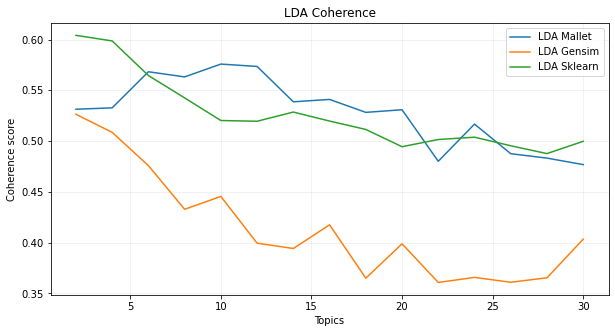

In [7]:
plot_coherence(cv1=coherence_values1,cv2=coherence_values2,cv3=coherence_values3,start=2,limit=31,step=2, figsize=(10,5), save = False)

In [8]:
# DF COHERENCES
c_summary = coherence_summary(cv_mallet=coherence_values1,cv_gensim=coherence_values2, cv_sklearn=coherence_values3,start=2,limit=31,step=2)
c_summary

,Nro Tópicos,LDA Mallet,LDA Gensim,LDA Sklearn
0,2,0.531355,0.526371,0.604091
1,4,0.532714,0.508601,0.598608
2,6,0.568258,0.475814,0.564543
3,8,0.563178,0.432862,0.542503
4,10,0.575800,0.445491,0.520247
5,12,0.573473,0.399481,0.519519
6,14,0.538670,0.394243,0.528577
7,16,0.541010,0.417591,0.519708
8,18,0.528267,0.365029,0.511448
9,20,0.530850,0.398854,0.494466


In [9]:
# GUARDAR DF COHERENCES EN EXCEL 
#c_summary.to_excel('Coherence_summary_obs.xlsx')

#### Top 15 words per topic - LDA MALLET

In [10]:
# TOP 15 WORDS X TOPIC - LDA MALLET
optimal_model1 = model_list1[11]
pprint(optimal_model1.print_topics(num_words=20, num_topics= 100))

[(0,
  '0.071*"bombo" + 0.065*"motor" + 0.042*"electrico" + 0.040*"tablero" + '
  '0.022*"normalizar" + 0.019*"cabezal" + 0.019*"sumergir" + 0.018*"electrica" '
  '+ 0.017*"cargar" + 0.016*"turbinar" + 0.014*"rele" + 0.013*"voltaje" + '
  '0.013*"medir" + 0.012*"cable" + 0.011*"voltio" + 0.011*"activar" + '
  '0.011*"alimentacion" + 0.010*"fase" + 0.010*"cortar" + 0.009*"energia"'),
 (1,
  '0.080*"tk" + 0.070*"reglar" + 0.069*"root" + 0.067*"veeder" + 0.048*"sump" '
  '+ 0.048*"sensor" + 0.036*"medicion" + 0.034*"consola" + 0.032*"alarmar" + '
  '0.022*"tank" + 0.019*"dispenser" + 0.017*"tabla" + 0.014*"estanque" + '
  '0.013*"diferenciar" + 0.012*"telemedicion" + 0.012*"tls" + '
  '0.011*"calibracion" + 0.011*"medir" + 0.010*"liquidar" + 0.010*"kerosene"'),
 (2,
  '0.091*"placa" + 0.050*"preset" + 0.042*"teclado" + 0.039*"sistema" + '
  '0.028*"bloquear" + 0.027*"control" + 0.026*"display" + 0.022*"orpak" + '
  '0.020*"encore" + 0.019*"gilbarco" + 0.018*"tarjeta" + 0.016*"personal" + 

#### Top 15 words per topic - LDA GENSIM

In [11]:
# TOP 15 WORDS X TOPIC - LDA GENSIM
optimal_model2 = model_list2[3]
pprint(optimal_model2.print_topics(num_words=15, num_topics= 100))

[(0,
  '0.036*"fallo" + 0.028*"hacer" + 0.021*"root" + 0.020*"veeder" + '
  '0.018*"trabajar" + 0.018*"revison" + 0.017*"informar" + 0.017*"electrico" + '
  '0.016*"tablero" + 0.015*"venta" + 0.015*"marcar" + 0.015*"consola" + '
  '0.014*"normal" + 0.013*"linear" + 0.013*"presion"'),
 (1,
  '0.066*"remplazar" + 0.055*"preset" + 0.052*"est" + 0.050*"opw" + '
  '0.043*"conv" + 0.042*"teclado" + 0.037*"oring" + 0.033*"enex" + '
  '0.033*"corresponder" + 0.031*"programar" + 0.029*"orpak" + 0.017*"soltar" + '
  '0.017*"precorte" + 0.014*"permitir" + 0.013*"capítulo"'),
 (2,
  '0.110*"mantencion" + 0.106*"calibrar" + 0.103*"preventivo" + 0.095*"disp" + '
  '0.063*"boca" + 0.032*"calibracion" + 0.026*"extraer" + 0.021*"spill" + '
  '0.021*"medidor" + 0.018*"adhesivo" + 0.018*"probar" + 0.015*"chequeo" + '
  '0.013*"parametros" + 0.011*"advantage" + 0.010*"reset"'),
 (3,
  '0.099*"cambiar" + 0.094*"equipar" + 0.071*"dispensador" + 0.053*"pistola" + '
  '0.045*"mal" + 0.042*"producto" + 0.030*"

#### Top 15 words per topic - LDA SKLEARN

In [12]:
# TOP 15 WORDS X TOPIC - LDA SKLEARN
optimal_model3 = model_list3[11]
top15words_sklearn(lda_model=optimal_model3,cv = cv)

TOPIC 0
['tapar', 'boca', 'descargar', 'limpieza', 'spill', 'pintar', 'verificacion', 'calibracion', 'volumetrica', 'interior', 'dispensador', 'surtidor', 'opw', 'litro', 'estancar']


TOPIC 1
['medidor', 'cambiar', 'reponer', 'ampolleta', 'codigo', 'quemar', 'wayne', 'advantage', 'administrador', 'gilbarco', 'banco', 'display', 'pls', 'bodega', 'comprar']


TOPIC 2
['estancar', 'producto', 'camara', 'verificar', 'error', 'contar', 'interno', 'posible', 'adjuntar', 'foto', 'pie', 'tc', 'succion', 'estanque', 'abril']


TOPIC 3
['gas', 'servicio', 'chequeo', 'informar', 'encargar', 'chequean', 'nuevo', 'administracion', 'efectuar', 'presentar', 'contar', 'tambien', 'trabajar', 'bueno', 'cable']


TOPIC 4
['mantencion', 'preventivo', 'calibrar', 'mes', 'calibracion', 'solo', 'programar', 'revolución', 'kero', 'lugar', 'mayar', 'julio', 'completo', 'externo', 'legacy']


TOPIC 5
['combustible', 'calibracion', 'entregar', 'corresponder', 'trabajo', 'tabla', 'proporcionar', 'gatillo', 'cont

In [13]:
# ASIGNAR EL MEJOR MODELO GLOBAL
optimal_model = optimal_model1  

<div class="alert alert-info" style="margin: 20px">Se elige el modelo LDA MALLET con 24 tópicos como modelo óptimo general, ya que es el que mejor se adapta a la situación en la empresa y al sector. Se hicieron pruebas con 6,10,14,16,18,20,22,24, 26 y 28 tópicos, siendo los primeros muy generales y los últimos ya incluian contenido sin sentido, por lo que 24 temas se considera una buena elección.</div>

## III. RESULTADOS DEL MEJOR MODELO LDA 

In [29]:
# VISUALIZAR TOPICOS - pyLDAvis
pyLDAvis.enable_notebook()
LDAmallet_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
vis = pyLDAvis.gensim.prepare(LDAmallet_gensim, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.183705 -0.230446       1        1  5.154828
11     0.148614 -0.020296       2        1  4.516812
17     0.071023  0.159822       3        1  4.482777
15     0.196133 -0.229262       4        1  4.460219
0      0.057337  0.121715       5        1  4.417482
1      0.123662  0.023904       6        1  4.414697
19    -0.007746  0.023106       7        1  4.376681
10     0.022276  0.069331       8        1  4.262653
16    -0.273784 -0.049042       9        1  4.255496
22    -0.184116 -0.205403      10        1  4.232202
14    -0.219374 -0.034390      11        1  4.178584
5     -0.232104 -0.044895      12        1  4.149344
6      0.050177  0.053615      13        1  4.125201
2      0.000475  0.139541      14        1  4.112939
8      0.093313 -0.000537      15        1  4.101303
20     0.057868  0.066768      16        1  4.055860
12    -0.293803 -0.061469      17        1  4.036766
23     0.141110 -0.291884      18        1  4.020877
3      0.035799  0.160330      19        1  3.940922
9     -0.098329  0.024188      20        1  3.911249
4      0.071136  0.095252      21        1  3.903589
21     0.013388  0.013405      22        1  3.771359
7      0.017595  0.106737      23        1  3.601069
13     0.025644  0.109907      24        1  3.517090, topic_info=             Term          Freq         Total Category  logprob  loglift
16    dispensador  10905.000000  10905.000000  Default  30.0000  30.0000
5        producto  10941.000000  10941.000000  Default  29.0000  29.0000
18        equipar   8786.000000   8786.000000  Default  28.0000  28.0000
1             gas   7849.000000   7849.000000  Default  27.0000  27.0000
0         cambiar  17089.000000  17089.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
449         hacer    251.590919    841.421516  Topic24  -4.2780   2.1402
148        swivel    124.175776   1155.538546  Topic24  -4.9841   1.1169
331         sacar    101.500199    482.090984  Topic24  -5.1857   1.7895
971           dar     95.021463    347.096824  Topic24  -5.2517   2.0520
421  proporcionar     90.702306    337.454741  Topic24  -5.2982   2.0337

[1829 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
4811     15  0.940750  abastemiento
2535      4  0.999744         abril
365       1  0.079290         abrir
365      11  0.921742         abrir
5866     10  1.078334     abundante
...     ...       ...           ...
4349     16  0.947849            wm
3067     14  0.972457           wue
3635     10  0.943542            xe
3817      5  0.964586        yumper
871      21  1.105926        zarate

[2164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 12, 18, 16, 1, 2, 20, 11, 17, 23, 15, 6, 7, 3, 9, 21, 13, 24, 4, 10, 5, 22, 8, 14])

#### Tópico dominante y su porcentaje de contribución

In [30]:
# TÓPICO DOMINANTE Y SU PORCENTAJE DE CONTRIBUCIÓN EN CADA DOC
pd.options.display.max_colwidth = 80
df_topic_sents_keywords = format_topics_sentences(ldamodel=LDAmallet_gensim, corpus=corpus, texts=texts)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.0705,"placa, preset, teclado, sistema, bloquear, control, display, orpak, encore, ...","[cambiar, placa, gas, placa, producto, pintar, tapar, idenficacion]"
1,1,23.0,0.0729,"boca, calibrar, equipo, preventivo, mantencion, limpiar, devolver, recircula...","[cambiar, graficas, equipo, contemplar, estacionar, delegar]"
2,2,3.0,0.2420,"despachar, venta, normal, isla, cliente, cortar, breakaway, formar, publicar...","[eds, chequeo, dispensador, diller, corto, rato, venta, programacion, reset,..."
3,3,4.0,0.0735,"incidencia, cerrar, ot, trabajar, informar, servicio, encargar, administrado...","[remplazar, graficas, contemplar, estacionar, delegar]"
4,4,4.0,0.0901,"incidencia, cerrar, ot, trabajar, informar, servicio, encargar, administrado...","[remplazar, graficas, contemplar, contratar, estacionar, delegar]"
5,5,4.0,0.0915,"incidencia, cerrar, ot, trabajar, informar, servicio, encargar, administrado...","[dia, lunes, hrs]"
6,6,11.0,0.2712,"aguar, estancar, litro, retirar, tambor, lts, estanque, camara, contaminar, ...","[retirar, aguar, gas, litro, gas, tk, diesel, litro, aguar, contaminar, tamb..."
7,7,3.0,0.0910,"despachar, venta, normal, isla, cliente, cortar, breakaway, formar, publicar...","[cliente, solucionar, semana, cliente, solucionar, semana]"
8,8,2.0,0.1161,"placa, preset, teclado, sistema, bloquear, control, display, orpak, encore, ...","[trabajar, gilbarco, surtidor, conectar, sistema, gp, box, trabajar, gilbarc..."
9,9,6.0,0.1198,"producto, prueba, chequeo, recircula, recirculacion, despachar, presentar, p...","[numeral, mecanico, defectuoso, reparacion, surtidor, recirculan, litro, pro..."


#### Distribución de los tópicos en BD

In [31]:
# DISTRIBUCIÓN DE LOS TÓPICOS A TRAVÉS DE LOS DOCS
pd.reset_option('^display.', silent=True)
df_topic_distribution = df_dominant_topic['Dominant_Topic'].value_counts().reset_index(name='Num Documents')
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.sort_values('Topic Num')

,Topic Num,Num Documents
11,0.0,891
10,1.0,942
8,2.0,1006
9,3.0,952
0,4.0,2145
18,5.0,581
21,6.0,483
7,7.0,1014
15,8.0,646
17,9.0,615


#### Oración representativa por cada tópico

In [32]:
# ORACIÓN MÁS REPRESENTATIVA POR CADA TÓPICO
pd.options.display.max_colwidth = 90
#pd.reset_option('^display.', silent=True)
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], axis=0)
    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Representative Text']
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.5771,"bombo, motor, electrico, tablero, normalizar, cabezal, sumergir, electrica, cargar, tu...","[circuito, alumbrar, salar, arquear, curcuito, forzar, curcuito, forzar, minemarket, s..."
1,1.0,0.5500,"tk, reglar, root, veeder, sump, sensor, medicion, consola, alarmar, tank","[indicar, diferenciar, reglar, medicion, veeder, root, estanque, estanque, peseta, con..."
2,2.0,0.4454,"placa, preset, teclado, sistema, bloquear, control, display, orpak, encore, gilbarco","[eds, chequeo, dispensador, despachar, combustible, lado, interior, placa, puerta, led..."
3,3.0,0.2845,"despachar, venta, normal, isla, cliente, cortar, breakaway, formar, publicar, reconect...","[dispensador, isla, despachar, gas, isla, isla, despachar, formar, normal, producto, o..."
4,4.0,0.4214,"incidencia, cerrar, ot, trabajar, informar, servicio, encargar, administrador, corresp...","[eds, ejecutar, calibracion, gas, ejecutar, encargar, surtidor, candar, tapar, inferio..."
5,5.0,0.4555,"dispensador, medidor, cambiar, gasolina, chequeo, advantage, gilbarco, encore, banco, ...","[chequeo, dispensador, detectar, fallo, medidor, trabar, solucita, reponer, medidor, a..."
6,6.0,0.3299,"producto, prueba, chequeo, recircula, recirculacion, despachar, presentar, presenciar,...","[chequeo, dispensador, producto, cambiar, valvula, proporcional, encore, equipar, prue..."
7,7.0,0.3273,"equipar, ajustar, palanca, reparar, partir, suelto, soltar, eliminar, accionamiento, r...","[dispensador, petrolear, diesel, boto, apoyar, pistola, palanca, accionamiento, mal, s..."
8,8.0,0.4073,"tapar, combustible, descargar, sellar, quebrar, instalar, nuevo, adaptador, foto, inst...","[pendiente, rremplazo, tapar, caja, vereda, quebrar, usocon, diametro, milímetro, espe..."
9,9.0,0.3551,"fallo, lado, probar, detectar, operar, cambiar, recirculando, malo, pulser, normalmente","[cambiar, pulser, lado, lado, probar, fallo, producir, ahora, lado, reponer, pra, camb..."


In [34]:
'''
df_dominant_topic.to_pickle('df_dominant_topic_obs.pkl')
df_topic_distribution.to_pickle('df_topic_distribution_obs.pkl')
sent_topics_sorteddf_mallet.to_pickle('sent_topics_sorteddf_mallet_obs.pkl')
'''

In [23]:
# CARGAR LOS DATA FRAMES ANTERIORES
df_dominant_topic = pd.read_pickle('df_dominant_topic_obs.pkl')
df_topic_distribution = pd.read_pickle('df_topic_distribution_obs.pkl')
sent_topics_sorteddf_mallet = pd.read_pickle('sent_topics_sorteddf_mallet_obs.pkl')

#### Nube de palabras

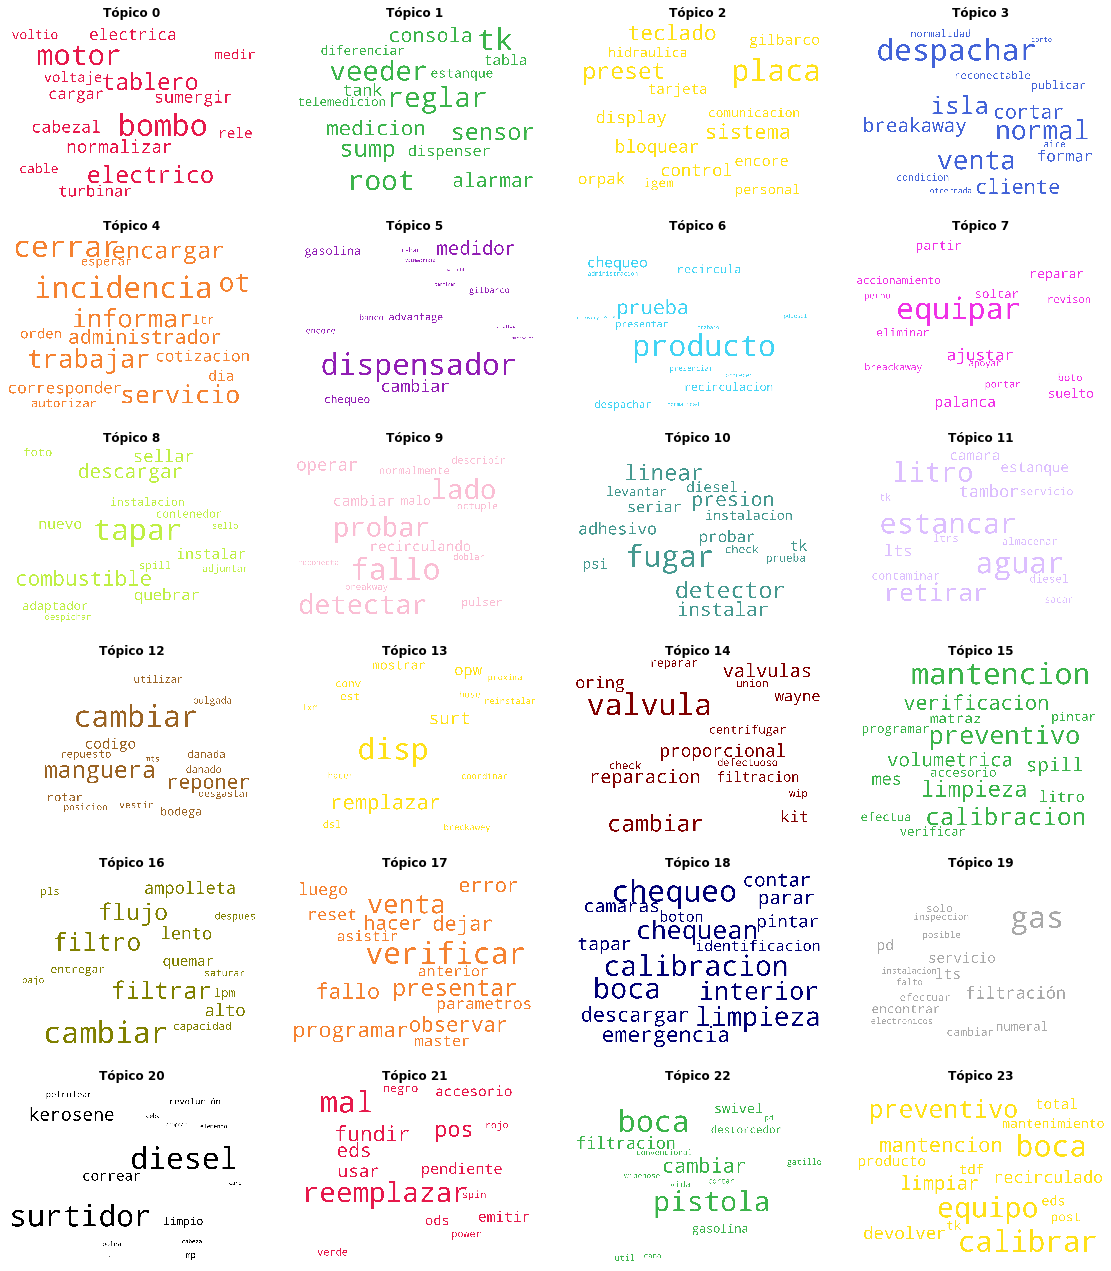

In [24]:
# NUBE DE PALABRAS
word_cloud(lda_model = optimal_model,rows = 6, cols = 4, figsize=(16,18),save = False)

#### Distribución de la frecuencia de palabras

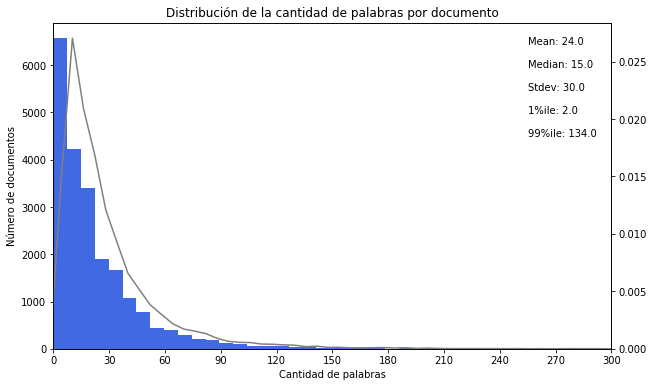

In [25]:
# DISTRIBUCIÓN DE LA FRECUENCIA DE LAS PALABRAS EN LOS DOCUMENTOS 
doc_lens = [len(d) for d in df_dominant_topic.Text]
plot_freqdist(doc_lens, bins = 100, width_text = 0.85, height_text = 0.65,figsize = (10,6), save = False)

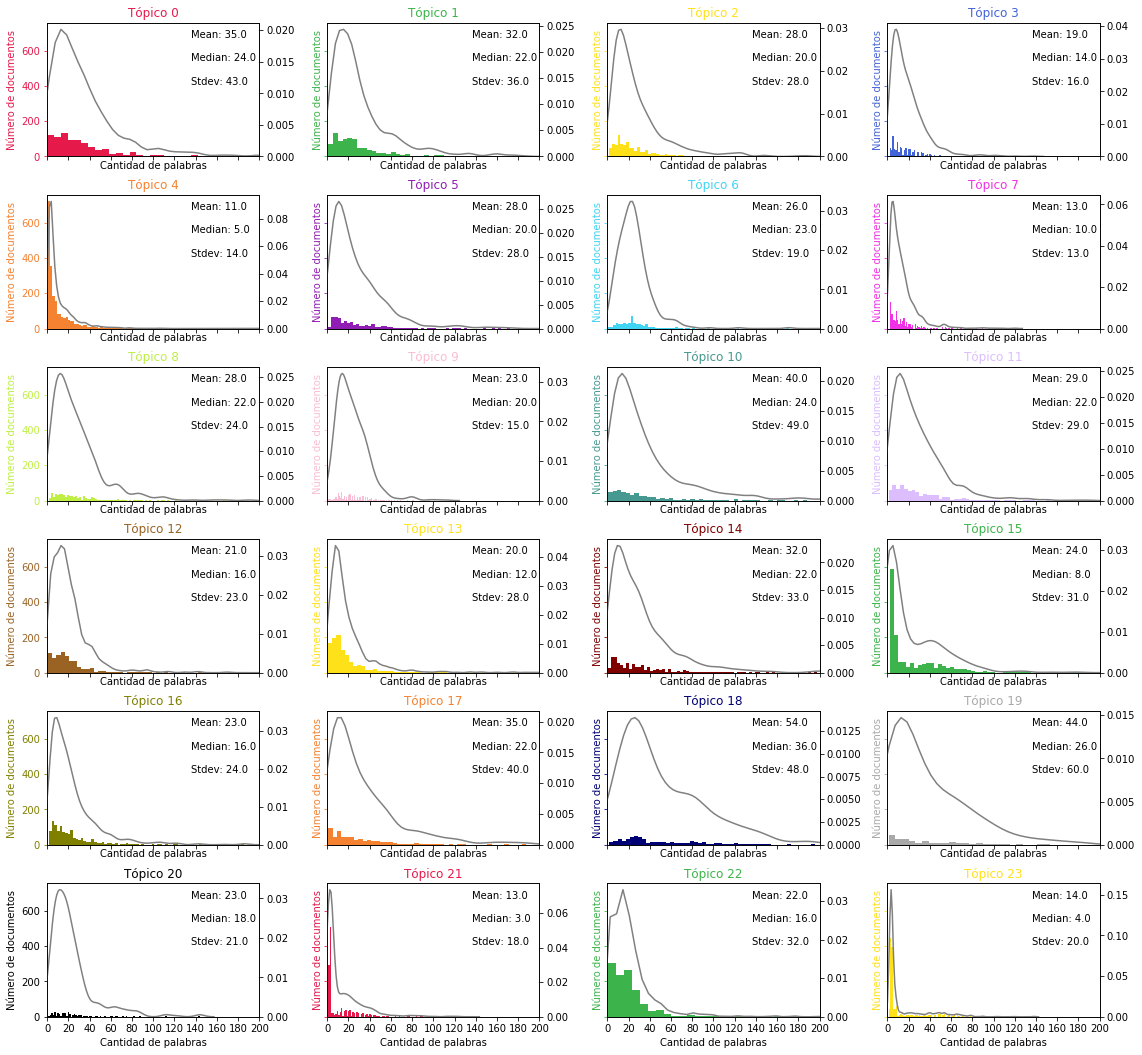

In [26]:
# DISTRIBUCIÓN DE LA FRECUENCIA DE LAS PALABRAS EN LOS TÓPICOS
plot_freqdist_topic(doc_lens,rows = 6, cols = 4, bins = 100,width_text=0.68, height_text= 0.54, figsize = (16,16), save = False)

<div class="alert alert-info" style="margin: 20px"> Se identifican 24 temas. El tópico 21 (ods mal emitida) registra la menor cantidad de palabras por oración, con un promedio de 13 ya que no se requiere mucho detalle para describir ese problema, mientras que el tópico 19 (actividades en estanques 93/95/97) requiere describir en mayor grado la situación por lo que se tiene en promedio 44 palabras por oración.</div>

## IV. EXTRACCIÓN DE INFORMACIÓN 

In [28]:
# TÓPICO DOMINANTE EN DF TOTAL
'''
pd.options.display.max_colwidth = 8
df_topic = df_total.copy()
df_topic['Topico Dominante'] = df_dominant_topic['Dominant_Topic']
df_topic['Topico Dominante'] = df_topic['Topico Dominante'].astype(int)
df_topic.to_pickle('BD_original_cleaned_TOPICO_DOMINANTE.pkl')
df_topic.to_excel('BD_original_cleaned_TOPICO_DOMINANTE.xlsx')
df_topic.head()
'''

"\npd.options.display.max_colwidth = 8\ndf_topic = df_total.copy()\ndf_topic['Topico Dominante'] = df_dominant_topic['Dominant_Topic']\ndf_topic['Topico Dominante'] = df_topic['Topico Dominante'].astype(int)\ndf_topic.to_pickle('BD_original_cleaned_TOPICO_DOMINANTE.pkl')\ndf_topic.to_excel('BD_original_cleaned_TOPICO_DOMINANTE.xlsx')\ndf_topic.head()\n"

In [13]:
df_topic = pd.read_pickle('BD_original_cleaned_TOPICO_DOMINANTE.pkl')
df_dominant_topic = pd.read_pickle('df_dominant_topic_obs.pkl')
df_topic_distribution = pd.read_pickle('df_topic_distribution_obs.pkl')
sent_topics_sorteddf_mallet = pd.read_pickle('sent_topics_sorteddf_mallet_obs.pkl')
df_topic.head()

,Region,Estacion,Tipo de Falla,Prioridad Cliente,Estado OT,Tecnico Asignado,Dia,Nro Dia,Mes,Hora,Rango Recep/Arribo,Rango Arribo/Cierre,Observación,Requerimiento,Topico Dominante
0,13°,Tingaro Spa.,Carrete Re...,Normal 48 ...,CERRADA,Juan Aliaga,Viernes,30,AGO 19,16,Error en f...,Más de 1 mes,se cambia ...,area de at...,2
1,8°,Combustibl...,Carrete Re...,Normal (48...,CERRADA,On Line,Viernes,30,AGO 19,12,Error en f...,Menos de 1h,cambio de ...,area de at...,23
2,10°,LLANOS Y W...,Carrete Re...,Normal 24 ...,PRECIERRE,Luis Almon...,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,se visita ...,area de at...,3
3,1°,Soc. Imp. ...,Carrete Re...,Normal (48...,CERRADA,On Line,Viernes,30,AGO 19,12,0 a 24 horas,Menos de 1h,remplazo d...,area de at...,4
4,3°,Inmobiliar...,Carrete Re...,Normal (48...,CERRADA,On Line,Viernes,30,AGO 19,12,Error en f...,Menos de 1h,remplazo d...,area de at...,4


In [14]:
df_topic.shape

(21840, 15)

#### Distribución de OT por tópico

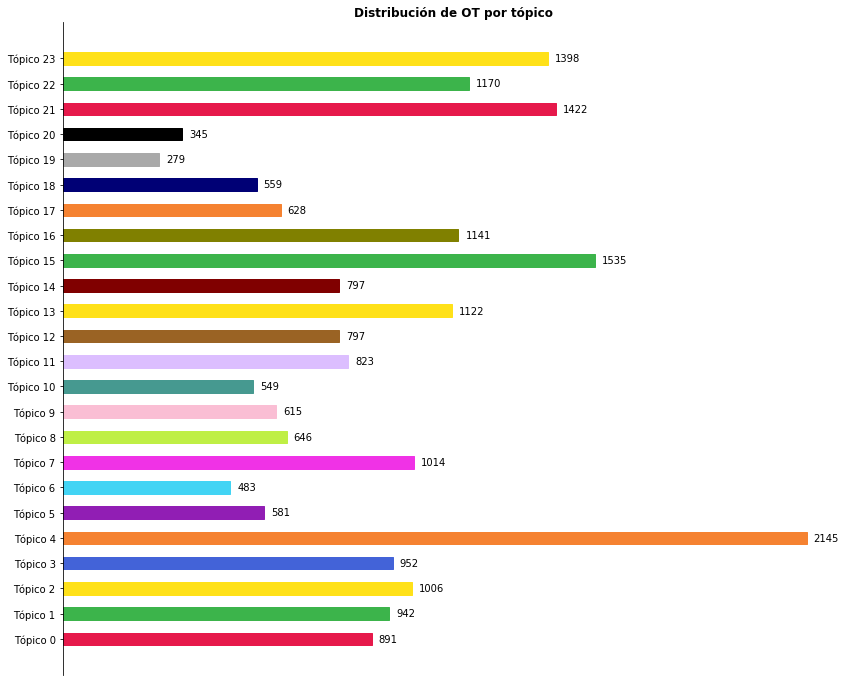

In [32]:
# DISTRIBUCIÓN DE OT POR TÓPICO
topic_distribution(name=None,namecol=None, df_topic=df_topic, vplus = 20,fontsize=12, figsize=(14,12), save = False)

#### Selección y análisis de un tópico K 

In [14]:
# TEXTO REPRESENTATIVO
keywords_text(topic_nro=0, df = sent_topics_sorteddf_mallet)

Top 10 palabras en Tópico 0
['bombo, motor, electrico, tablero, normalizar, cabezal, sumergir, electrica, cargar, turbinar']

Texto representativo en Tópico 0
[['circuito', 'alumbrar', 'salar', 'arquear', 'curcuito', 'forzar', 'curcuito', 'forzar', 'minemarket', 'sevmide', 'consumir', 'mimento', 'prender', 'herbidor', 'electrico', 'consumir', 'fase', 'automatico', 'general', 'circuito', 'subre', 'cargar', 'bajo', 'cortar', 'energia', 'electrica', 'ilumunacion', 'forzar', 'salar', 'arquear', 'curcuio', 'forzar', 'minemarket', 'envio', 'automatico', 'amp', 'amp', 'cambiar', 'automatico', 'ocaciones', 'consumir', 'superar', 'reponer', 'comprar', 'zona', 'circuito', 'alumbrar', 'salar', 'arquear', 'curcuito', 'forzar', 'curcuito', 'forzar', 'minemarket', 'sevmide', 'consumir', 'mimento', 'prender', 'herbidor', 'electrico', 'consumir', 'fase', 'automatico', 'general', 'circuito', 'subre', 'cargar', 'bajo', 'cortar', 'energia', 'electrica', 'ilumunacion', 'forzar', 'salar', 'arquear', 'curcu

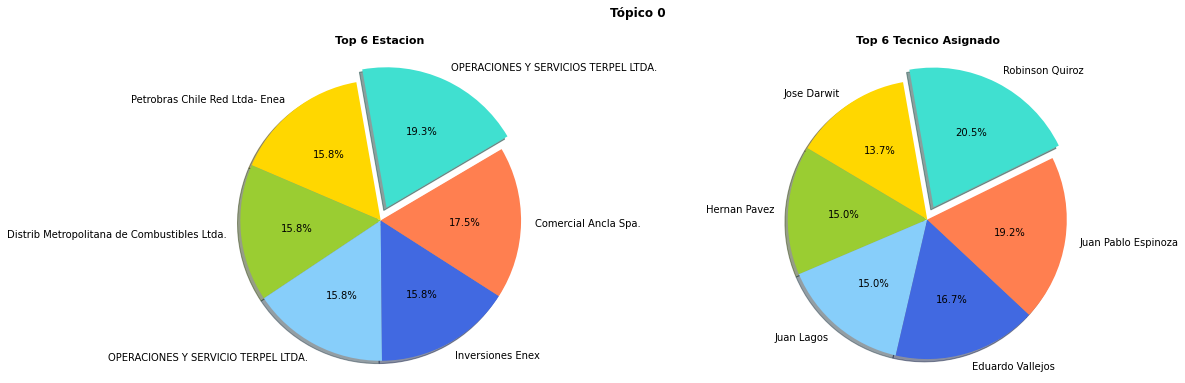

In [15]:
# Distribución de top 6 estaciones y top 6 técnicos en tópico anterior
topic_col1_col2(topic_nro=0, namecol1='Estacion', namecol2='Tecnico Asignado', df=df_topic, figsize = (18,6), save = True)

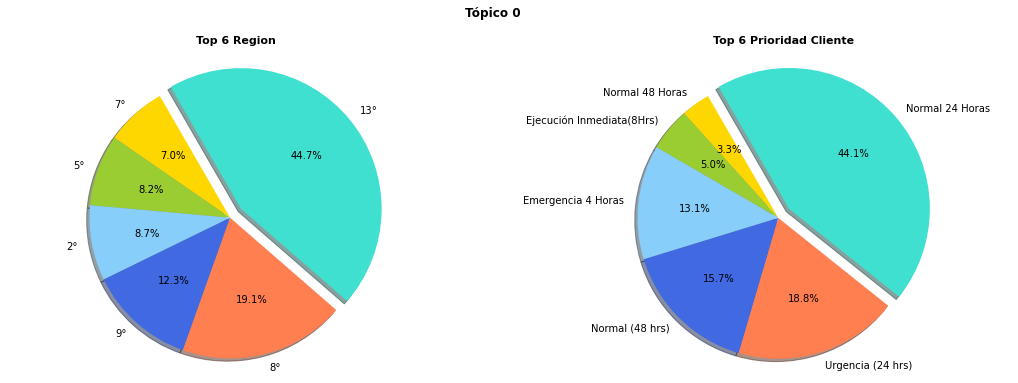

In [17]:
# Distribución de top 6 regiones y top 6 prioridad cliente en tópico anterior
topic_col1_col2(topic_nro=0, namecol1='Region', namecol2='Prioridad Cliente', df=df_topic, figsize = (18,6), save = True, angle = 120)

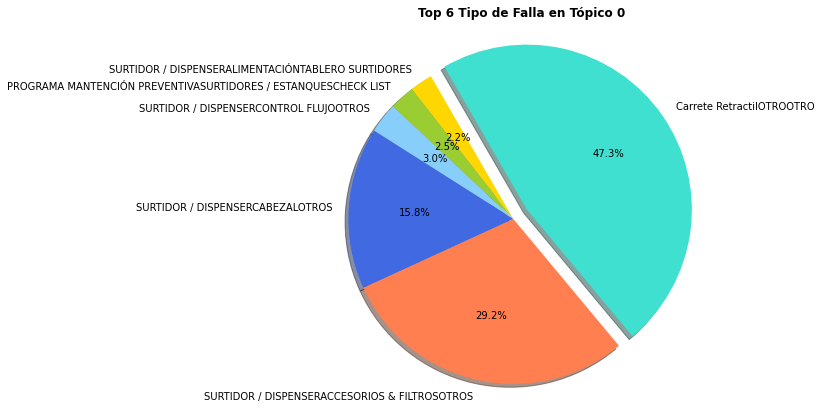

In [18]:
topic_namecol1(topic_nro=0, namecol = 'Tipo de Falla', df=df_topic, angle=120,figsize = (10,7), save = True)

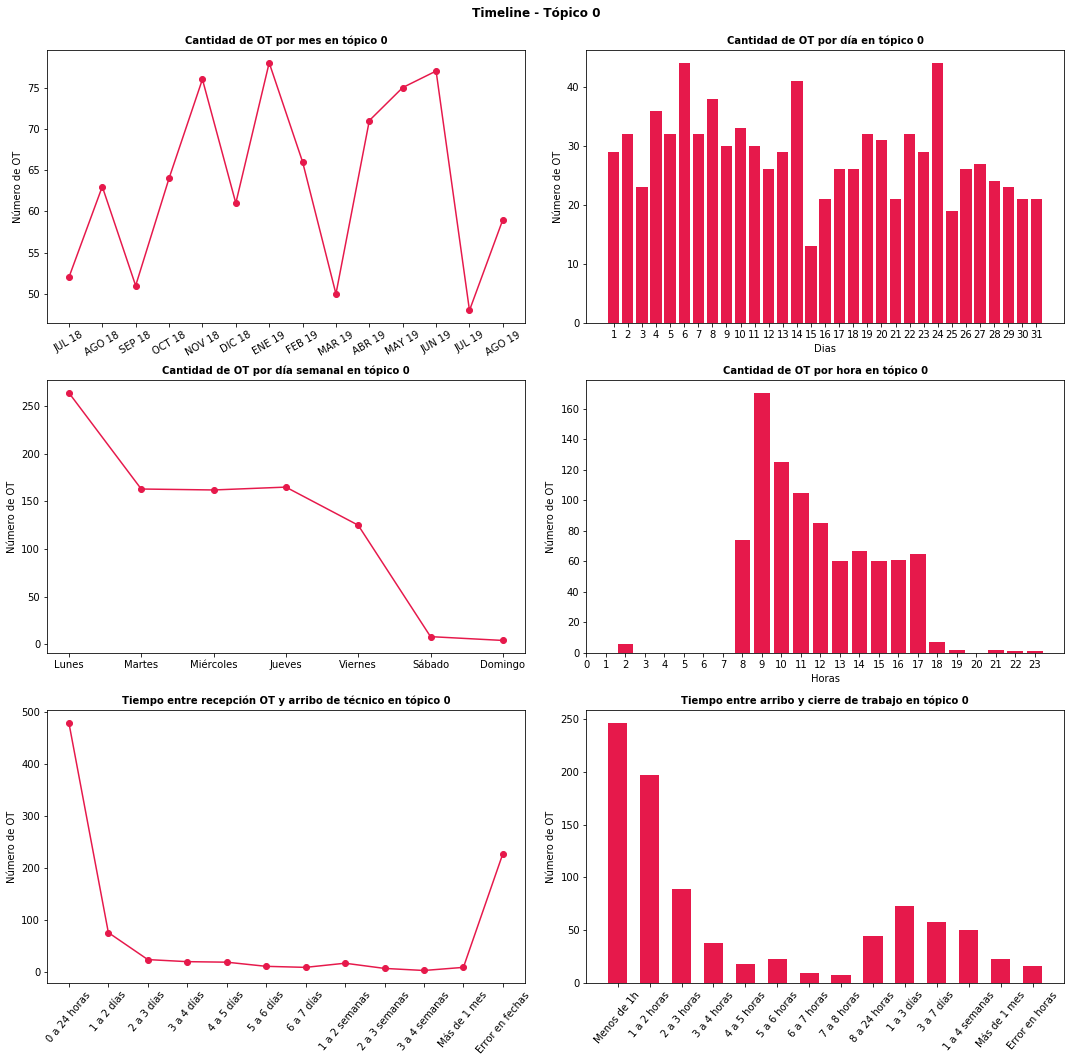

In [51]:
# Evolución de topico anterior con el paso del tiempo (meses, dias nro y horas)                                                              
topic_timeline(name=None, namecol = None, topic_nro=0, df_topic = df_topic, figsize=[15,15], save = False)

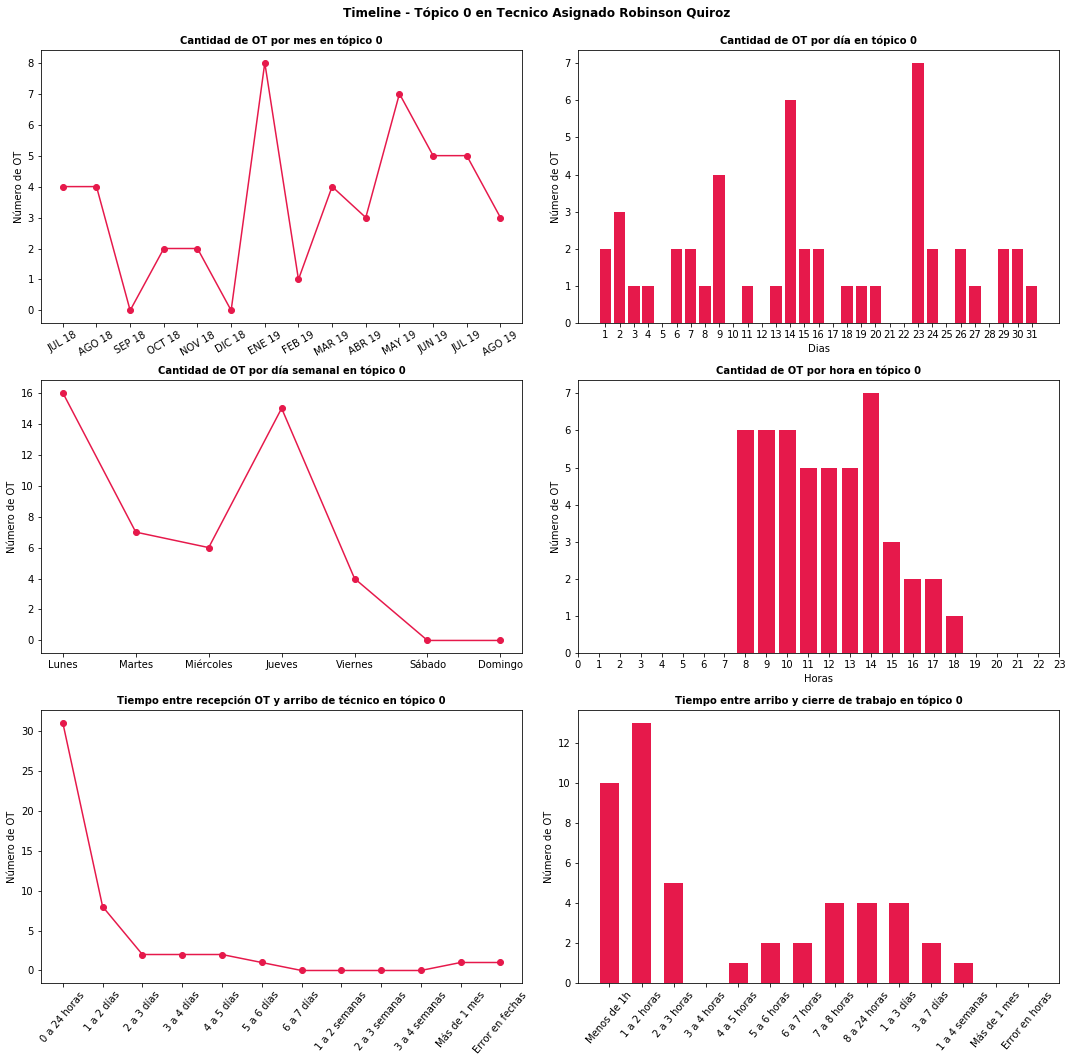

In [52]:
# Mismo tópico, pero ahora timeline exclusiva en un atributo (ROBINSON QUIROZ - TECNICO)                                                           
topic_timeline(name='Robinson Quiroz', namecol = 'Tecnico Asignado', topic_nro=0, df_topic = df_topic, figsize=[15,15], save = False)

#### Tópicos en estaciones top 10

Número de estaciones: 999


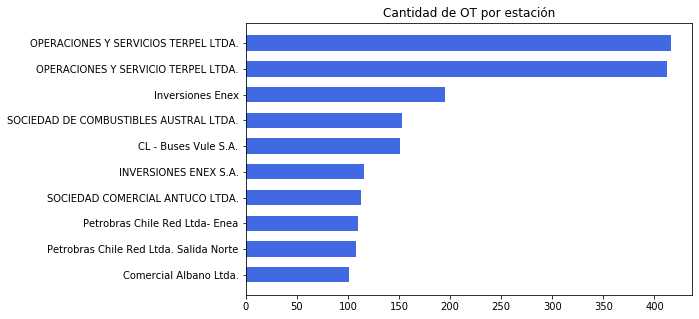

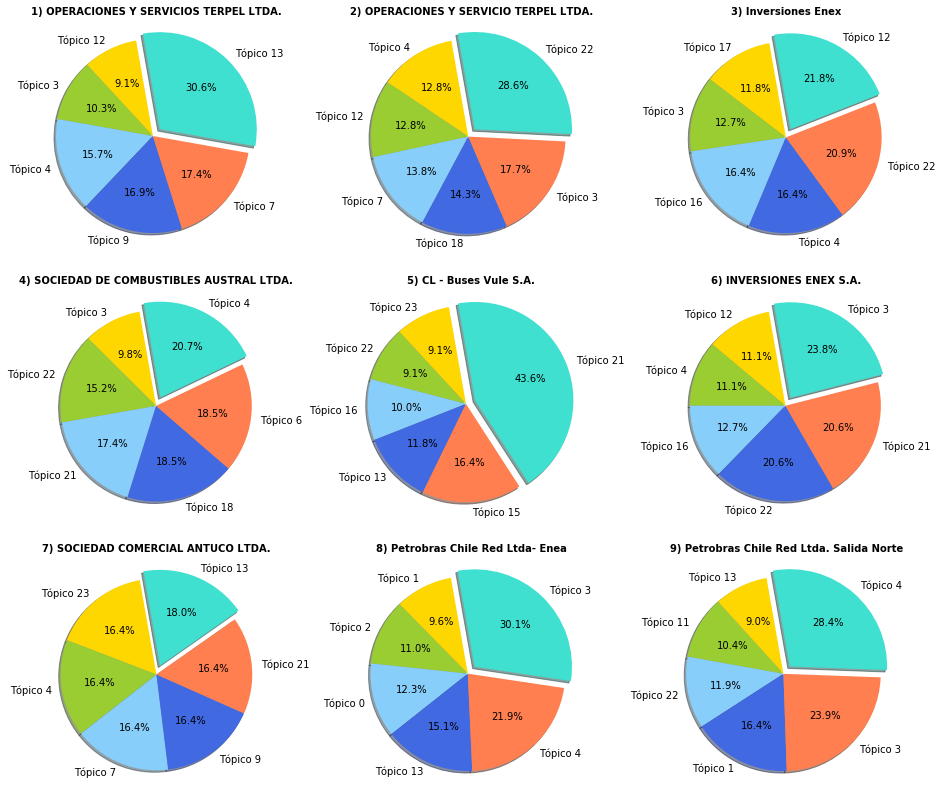

In [53]:
# PORCENTAJE DE TÓPICOS EN TOP 10 ESTACIONES CON MÁS OT
df = df_topic.copy()
print((f"\033[1mNúmero de estaciones: {len(sorted(df['Estacion'].unique()))}\033[0m"))
estacion_total= Counter(df["Estacion"])
dic_est_total = estacion_total.most_common(10)
keys_est_total = [i for i,v in dic_est_total][::-1]
values_est_total = [v for i,v in dic_est_total][::-1]
plt.rcParams.update({'figure.figsize':(8,5)})
plt.barh(keys_est_total,values_est_total, align = 'center', color = 'royalblue', height=0.6)
plt.title("Cantidad de OT por estación")
plt.show()
print('\n')
topics_top9(namecol='Estacion', df=df_topic, figsize = (16,14))

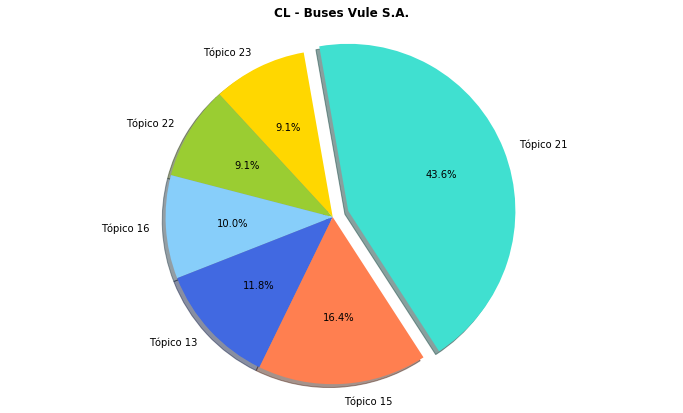

In [54]:
# PORCENTAJE DE TOPICOS EN UN SOLO ITEM
topics_top1(name= 'CL - Buses Vule S.A.', namecol= 'Estacion', df = df_topic, figsize=(12,7))

In [55]:
# SELECCIONAR UN TÓPICO PARA ANALIZAR
keywords_text(topic_nro=21, df = sent_topics_sorteddf_mallet)

Top 10 palabras en Tópico 21
['mal, reemplazar, pos, fundir, eds, usar, pendiente, emitir, accesorio, ods']

Texto representativo en Tópico 21
[['reemplazar', 'fundir', 'rojo', 'mas', 'mangar', 'plastico', 'pos', 'power', 'mal', 'pos', 'reemplazar', 'fundir', 'negro', 'perforar', 'usar', 'diesel', 'pendiente', 'cambiar', 'fundir', 'verde', 'pos', 'producto', 'perforar', 'pendiente', 'manguera', 'pos', 'power', 'aplastar', 'vehicular', 'pos', 'boca', 'reemplazar', 'cubrir', 'pistola', 'pos', 'reemplazar', 'cubrir', 'pistola', 'boca', 'perforar', 'usar', 'pos', 'reelazada', 'manguera', 'aplastar', 'vehicular', 'equipo', 'accesorio', 'mal', 'eds', 'reemplazar', 'fundir', 'rojo', 'mas', 'mangar', 'plastico', 'pos', 'power', 'mal', 'pos', 'reemplazar', 'fundir', 'negro', 'perforar', 'usar', 'diesel', 'pendiente', 'cambiar', 'fundir', 'verde', 'pos', 'producto', 'perforar', 'pendiente', 'manguera', 'pos', 'power', 'aplastar', 'vehicular', 'pos', 'boca', 'reemplazar', 'cubrir', 'pistola', 'po

#### Tópicos en OT pendientes

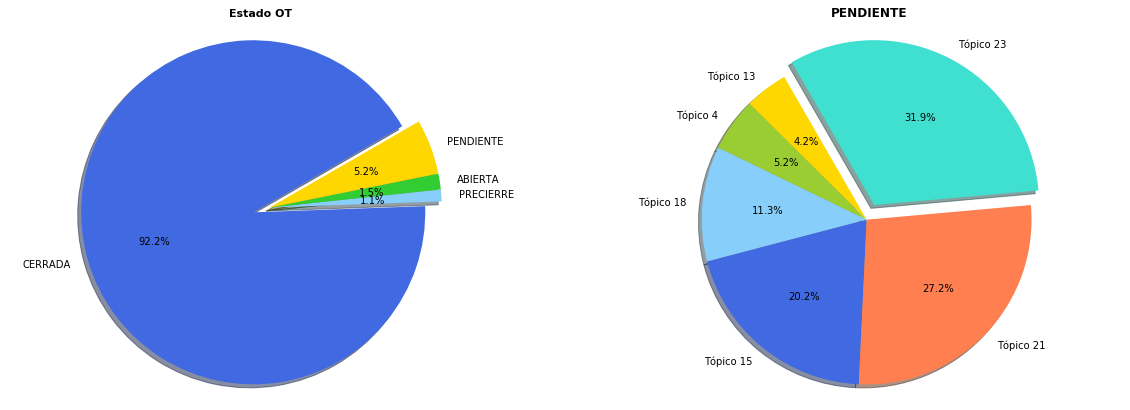

In [56]:
# ESTADO OT - PENDIENTES

plt.figure(1, figsize=(20,7))
plt.subplot(1,2,1)
estadoot_total = Counter(df_topic["Estado OT"])
colors3 = ['royalblue' ,'lightskyblue', 'limegreen', 'gold']
explode = (0.1, 0.0, 0, 0)  # explode 1st slice
keys_ottotal = [i for i in estadoot_total.keys()]
values_ottotal = [i for i in estadoot_total.values()]

plt.pie(values_ottotal,explode=explode, labels=keys_ottotal, colors = colors3,autopct='%1.1f%%', shadow=True, startangle=30)
plt.axis('equal')
plt.title("Estado OT", fontweight="bold", fontdict={'fontsize':11})

plt.subplot(1,2,2)
topics_top1(name= 'PENDIENTE', namecol= 'Estado OT', df = df_topic, angle = 120,figsize=(12,7) )

In [57]:
# Viendo el tópico 23 contienen más pendientes
keywords_text(topic_nro = 23, df = sent_topics_sorteddf_mallet)

Top 10 palabras en Tópico 23
['boca, calibrar, equipo, preventivo, mantencion, limpiar, devolver, recirculado, total, producto']

Texto representativo en Tópico 23
[['mantenimiento', 'preventivo', 'calibrar', 'boca', 'limpiar', 'equipo', 'producto', 'recirculado', 'devolver', 'tk', 'equipar', 'tdf', 'mantenimiento', 'preventivo', 'calibrar', 'boca', 'limpiar', 'equipo', 'producto', 'recirculado', 'devolver', 'tk', 'equipar', 'tdf', 'mantenimiento', 'preventivo', 'calibrar', 'boca', 'limpio', 'equipar', 'reemplazar', 'pistola', 'filtracion', 'producto', 'recirculado', 'devolver', 'tk', 'equipar', 'tdf', 'mantenimiento', 'preventivo', 'calibrar', 'boca', 'limpiar', 'equipo', 'producto', 'recirculado', 'devolver', 'tk', 'equipar', 'tdf', 'mantenimiento', 'preventivo', 'calibrar', 'boca', 'limpiar', 'equipo', 'producto', 'recirculado', 'devolver', 'tk', 'equipar', 'tdf', 'mantenimiento', 'preventivo', 'calibrar', 'boca', 'limpio', 'equipar', 'reemplazar', 'pistola', 'filtracion', 'producto

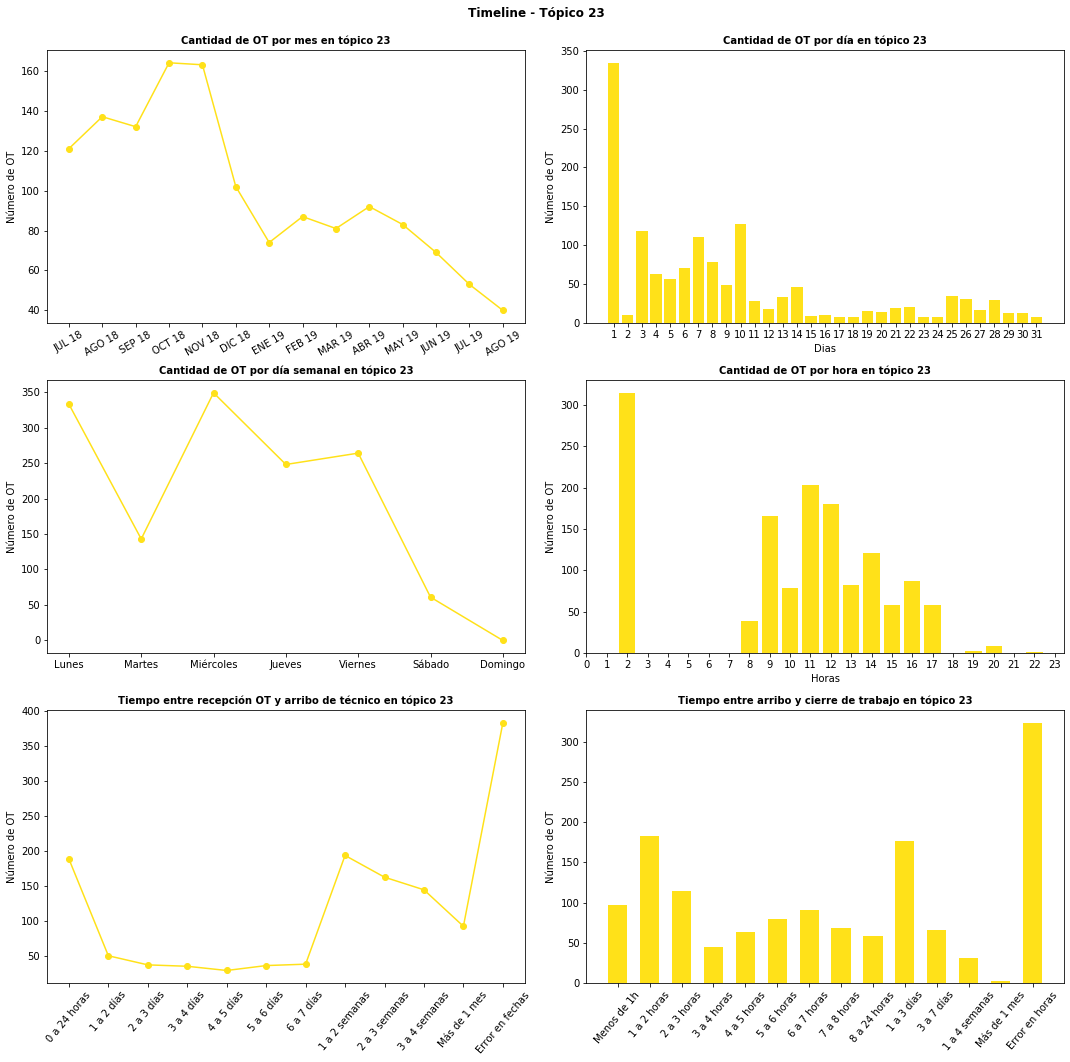

In [64]:
# Analizando todo el tópico 23 en el tiempo debido a las OT pendientes                                                            
topic_timeline(name=None, namecol = None, topic_nro=23, df_topic = df_topic, figsize=(15,15), save = False)

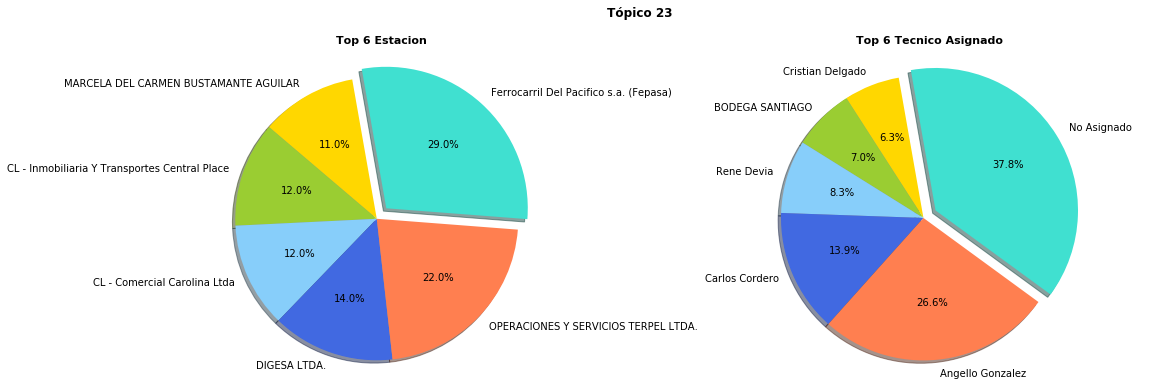

In [65]:
# TOPICO 23 
topic_col1_col2(topic_nro=23, namecol1='Estacion', namecol2='Tecnico Asignado', df=df_topic, figsize = (18,6), save = False)

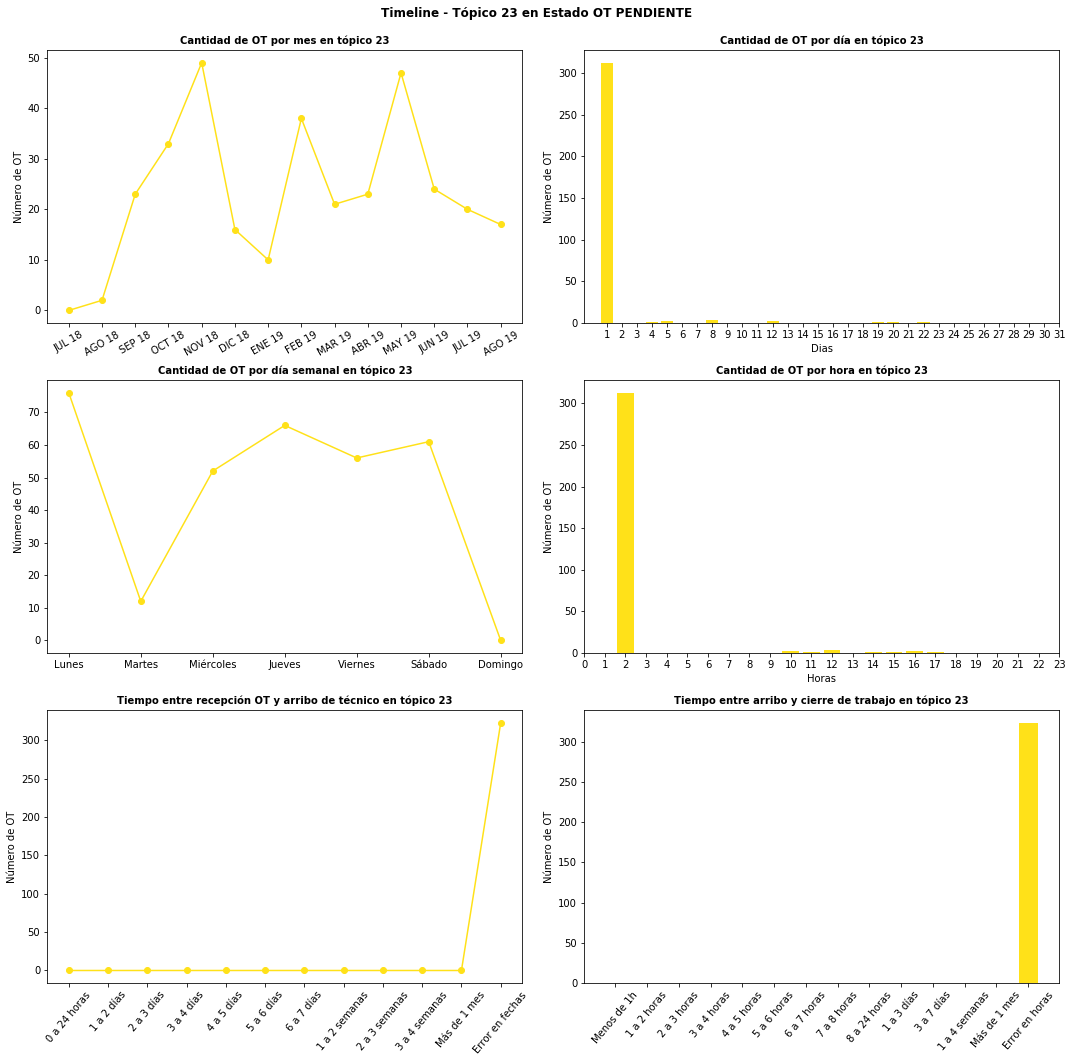

In [67]:
# Tópico 23 exclusivo en OT pendientes                                                             
topic_timeline(name='PENDIENTE', namecol = 'Estado OT', topic_nro=23, df_topic = df_topic, figsize=(15,15), save = False)

#### Tópicos en regiones 

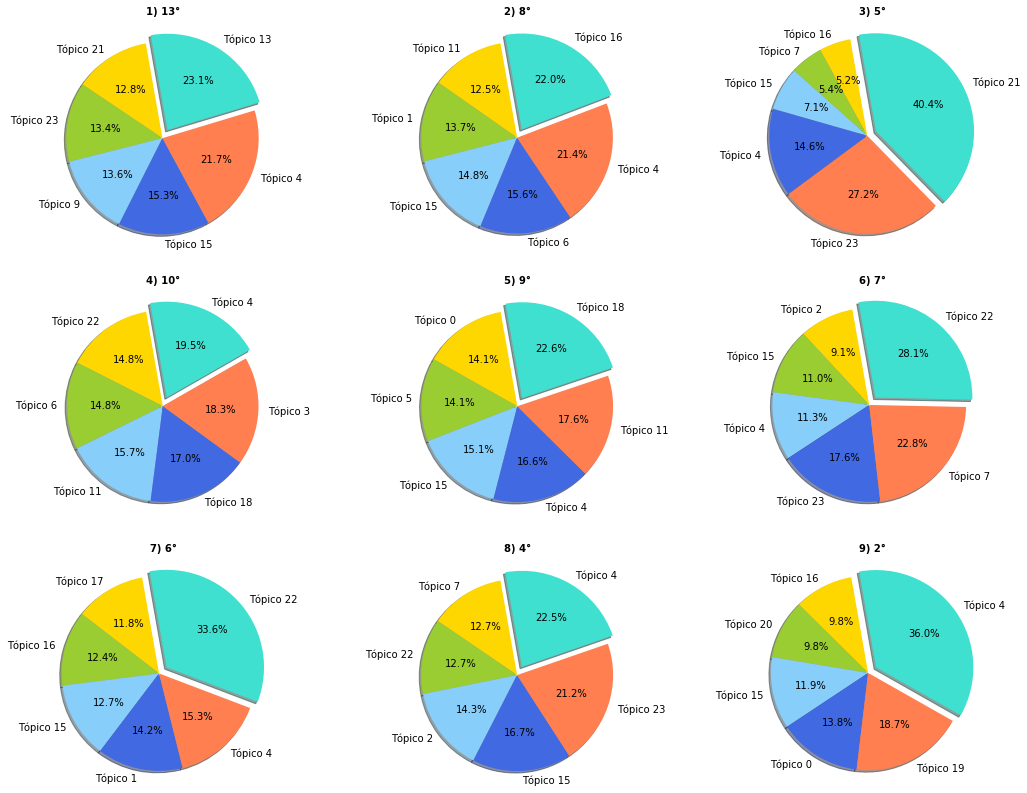

In [68]:
# REGIONES
topics_top9(namecol='Region',df=df_topic)

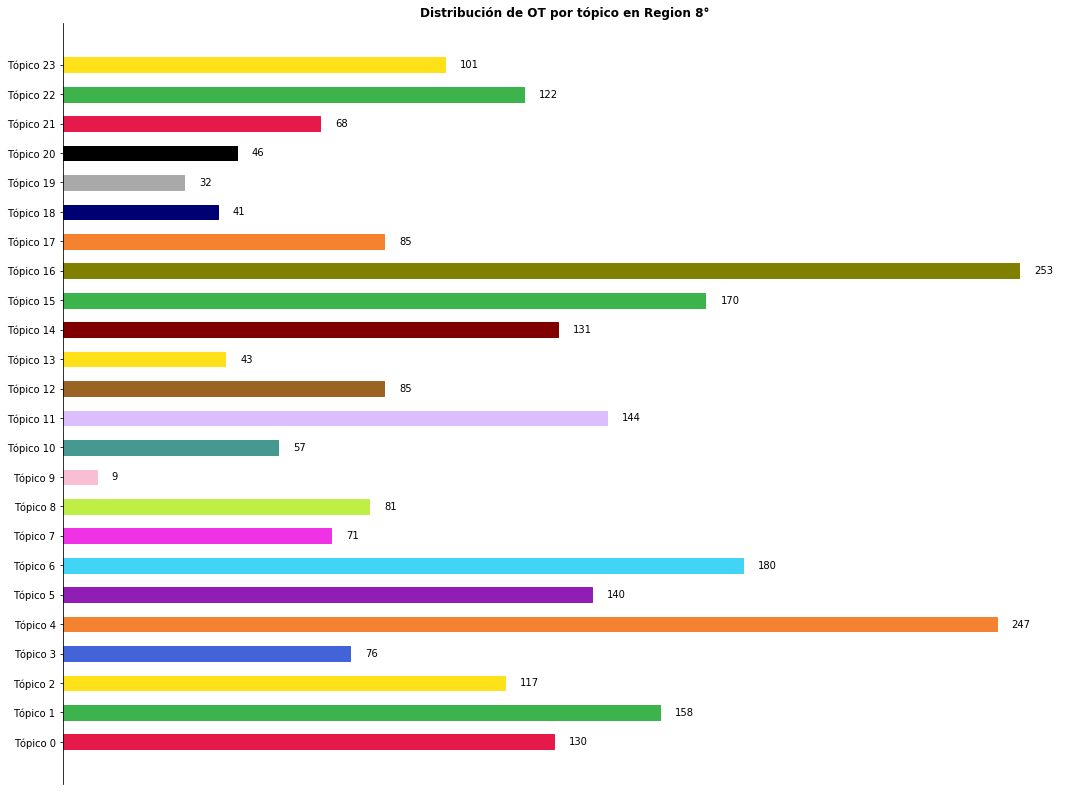

In [69]:
# EN REGION DEL BIO-BIO (8°)
topic_distribution(name= '8°', namecol='Region', df_topic= df_topic, vplus=4,figsize=(14,12), fontsize = 12)

#### Tópicos en técnicos asignados

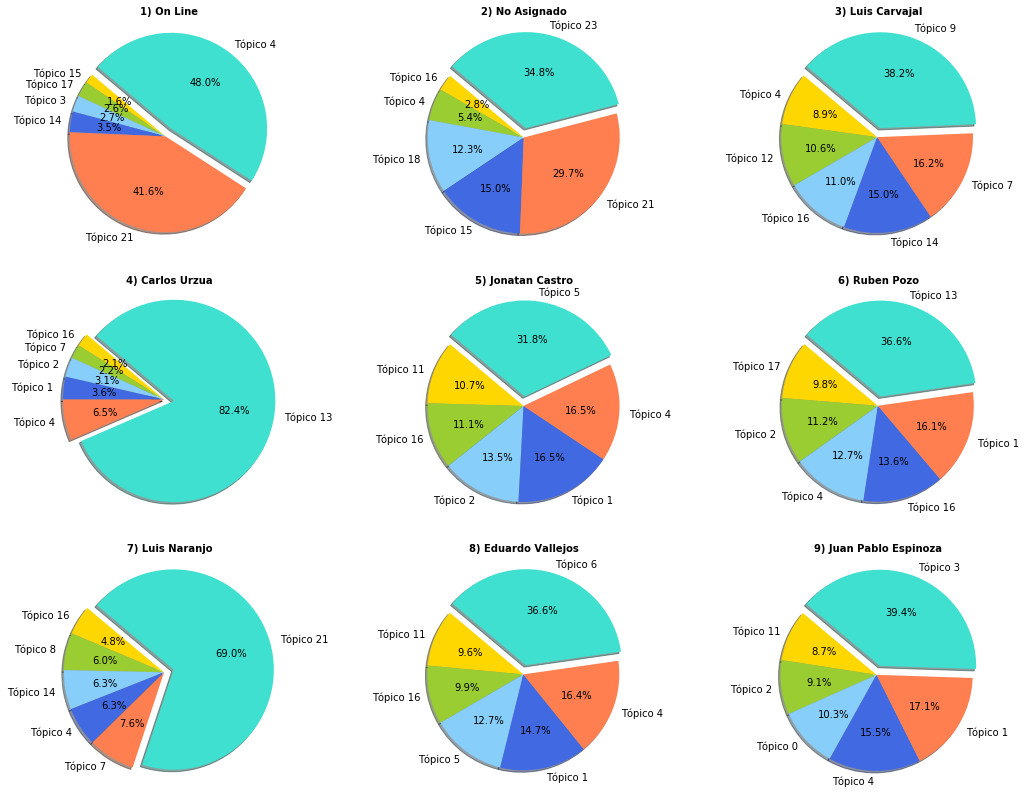

In [70]:
# TECNICOS ASIGNADOS
topics_top9(namecol='Tecnico Asignado',df=df_topic, angle = 140)

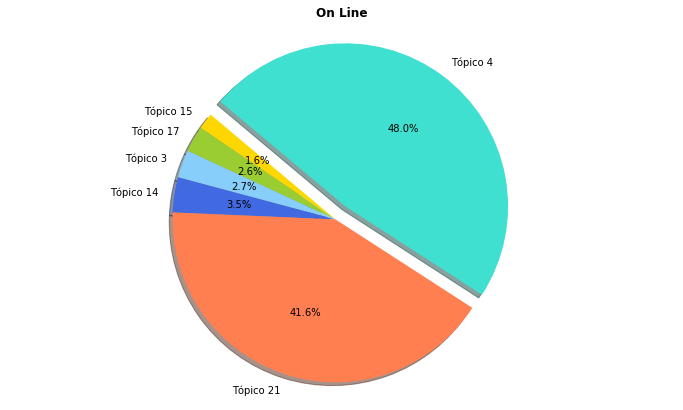

In [71]:
# Seleccionando solo un item para ver de cerca
topics_top1(name= 'On Line', namecol= 'Tecnico Asignado', df = df_topic, angle = 140,figsize=(12,7))

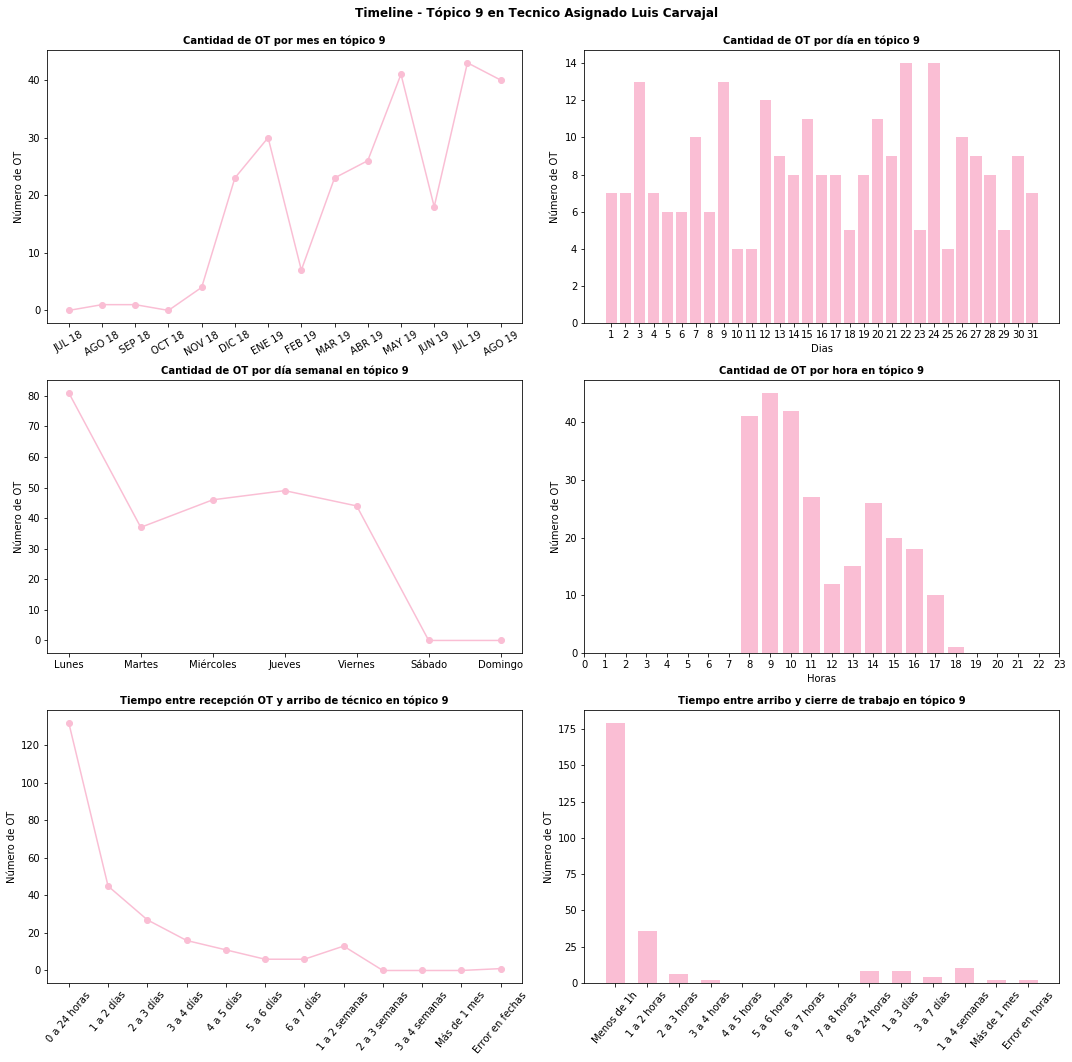

In [73]:
# Seleccionando a Luis Carvajal 
topic_timeline(name='Luis Carvajal', namecol = 'Tecnico Asignado', topic_nro=9, df_topic = df_topic, figsize=(15,15), save = False)

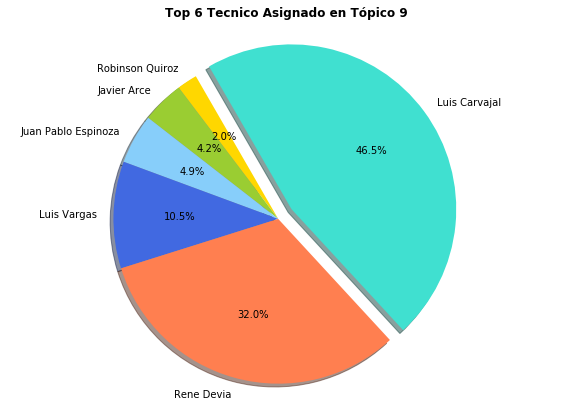

In [74]:
# Será Luis Carvajal el técnico con más OT en tópico 9 ? 
topic_namecol1(topic_nro=9, namecol = 'Tecnico Asignado', df=df_topic, angle=120,figsize = (10,7), save = False)

Efectivamente, Luis Carvajal concentra el mayor porcentaje de los trabajos realizados con Tópico 9

#### Tópicos en prioridad cliente

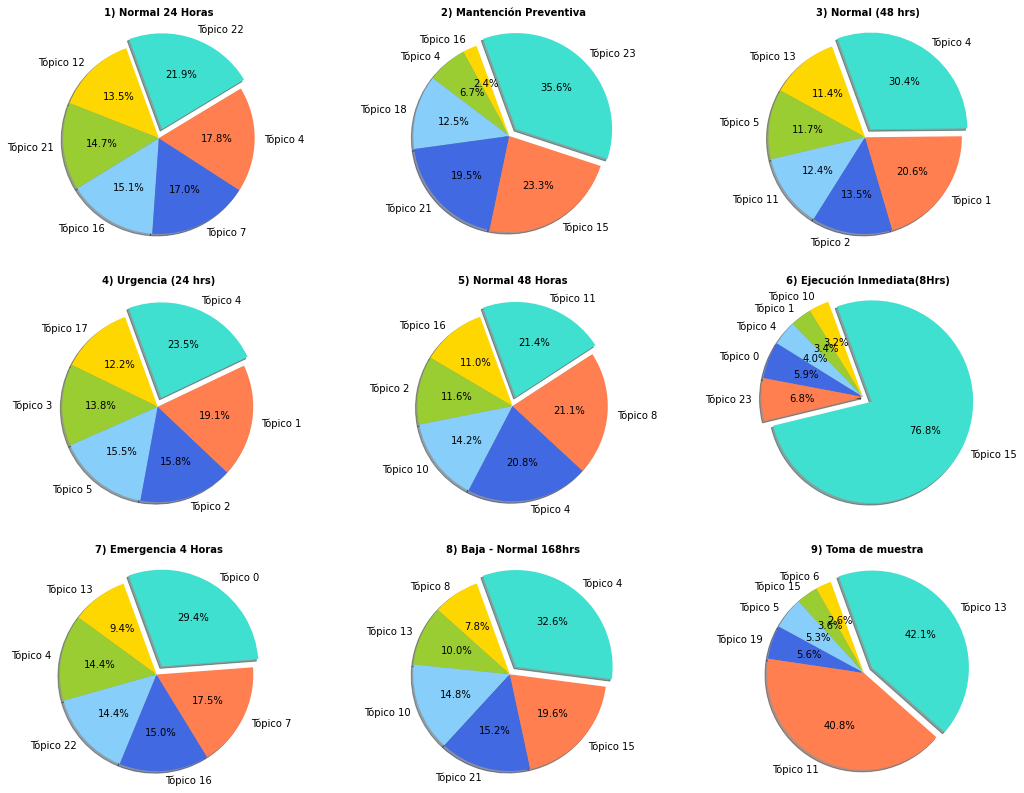

In [16]:
# Prioridad Cliente
topics_top9(namecol='Prioridad Cliente',df=df_topic, save = False, angle=110)